# Table of Contents
 <p><div class="lev1 toc-item"><a href="#code-flow" data-toc-modified-id="code-flow-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>code flow</a></div><div class="lev2 toc-item"><a href="#calibration-from-'camera_cal'" data-toc-modified-id="calibration-from-'camera_cal'-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>calibration from 'camera_cal'</a></div><div class="lev1 toc-item"><a href="#final-Parameter" data-toc-modified-id="final-Parameter-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>final Parameter</a></div><div class="lev1 toc-item"><a href="#final" data-toc-modified-id="final-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>final</a></div><div class="lev1 toc-item"><a href="#完成品" data-toc-modified-id="完成品-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>完成品</a></div>

In [1]:
import os

In [2]:
os.listdir('./'), os.listdir('./camera_cal/'), os.listdir('./test_images/')

(['.DS_Store',
  '.git',
  '.ipynb_checkpoints',
  'camera_cal',
  'challenge_video.mp4',
  'harder_challenge_video.mp4',
  'implementation.ipynb',
  'mini.mp4',
  'mymini.mp4',
  'myproject.mp4',
  'project_video.mp4',
  'README.md',
  'test_images'],
 ['calibration1.jpg',
  'calibration10.jpg',
  'calibration11.jpg',
  'calibration12.jpg',
  'calibration13.jpg',
  'calibration14.jpg',
  'calibration15.jpg',
  'calibration16.jpg',
  'calibration17.jpg',
  'calibration18.jpg',
  'calibration19.jpg',
  'calibration2.jpg',
  'calibration20.jpg',
  'calibration3.jpg',
  'calibration4.jpg',
  'calibration5.jpg',
  'calibration6.jpg',
  'calibration7.jpg',
  'calibration8.jpg',
  'calibration9.jpg'],
 ['solidWhiteRight.jpg',
  'solidYellowLeft.jpg',
  'test1.jpg',
  'test2.jpg',
  'test3.jpg',
  'test4.jpg',
  'test5.jpg',
  'test6.jpg'])

# code flow
(a) calibrate distorted images by 'camera_cal' directories      
(b) read movie and getimages  
(c) get bird's view                                                   
(d) get lines by sobel transformation and HLS conversion    
(e) measuring curvature  
(f) addweighted red lines  
(g)  execute full program

## calibration from 'camera_cal'

In [4]:
#import tensorflow as tf
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
#%matplotlib qt

In [1367]:
def get_calibration_param(image_url):
    images = glob.glob(image_url)

    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    corner = (9, 6)
    
    for image in images:
        img = mpimg.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, corner, None)

        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    print("finish get_calibration_param")
    return objpoints, imgpoints, mtx, dist

objpoints, imgpoints, mtx, dist = get_calibration_param('./camera_cal/calibration*.jpg')
np.savez("./calibration.npz", objpoints=objpoints, imgpoints=imgpoints, mtx=mtx, dist=dist)

finish get_calibration_param


In [1368]:
%matplotlib inline
def get_undistortion(img, objopints, imgpoints, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [1369]:
def get_birdeye(undist, src, dst):
    img_size = (undist.shape[1], undist.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped, M

In [1370]:
def get_S_Of_HLS(warped):
    hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
    s = hls[:, :, 2]
    retval, s_binary = cv2.threshold(s.astype('uint8'), 110, 255, cv2.THRESH_BINARY)
    return s_binary

In [1371]:
def get_slopex(warped):
    gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    slopex = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    scale_factor = np.max(slopex) / 255
    scale_slopex = (slopex / scale_factor).astype(np.uint8)
    retval, sx_binary = cv2.threshold(scale_slopex, 15, 150, cv2.THRESH_BINARY)
    return sx_binary

In [1372]:
def get_final_conversion(warped):
    s = get_S_Of_HLS(warped)
    slopex = get_slopex(warped)
    #color_binary = np.dstack(( np.zeros_like(slopex), slopex, s))
    color_binary = s
    return color_binary

In [1373]:
def get_lines(image):
    return left_lines, right_lines

In [1374]:
def get_curveLine(line):
    return line

In [1375]:
calibration_param = np.load('./calibration.npz')
objpoints  = calibration_param['objpoints']
imgpoints = calibration_param['imgpoints']
mtx = calibration_param['mtx']
dist = calibration_param['dist']

img_size = (1280, 720)
src = np.float32([np.array([[img_size[0]*29./64., 450]]), np.array([[img_size[0] * 35. /64, 450]]),
                  np.array([[img_size[0] *7. / 8, img_size[1]]]), np.array([[img_size[0] * 1. / 8, img_size[1]]])])
dst = np.float32([np.array([[img_size[0]/4, 0]]), np.array([[img_size[0] * 3 / 4, 0]]),
                  np.array([[img_size[0]*3/4, img_size[1]]]), np.array([[img_size[0] / 4, img_size[1]]])])

def process_image(image):
    global objpoints; global imgpoints; global src; global dst; global mtx; global dist;
    undist = get_undistortion(image, objpoints, imgpoints, mtx, dist)
    top_down, perspective_M = get_birdeye(undist, src, dst)
    result = get_final_conversion(top_down)
    return result

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = './mymini.mp4'
clip1 = VideoFileClip('./mini.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./mymini.mp4
[MoviePy] Writing video ./mymini.mp4


 99%|█████████▊| 74/75 [00:45<00:00,  1.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./mymini.mp4 

CPU times: user 48.2 s, sys: 648 ms, total: 48.9 s
Wall time: 46.2 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./mini.mp4'))

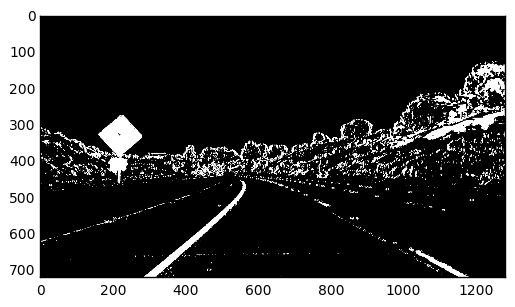

In [1336]:
image = mpimg.imread('./test_images/test2.jpg')
undist, s, slopex, top_down, result = process_image(image)
plt.imshow(result, cmap='gray')

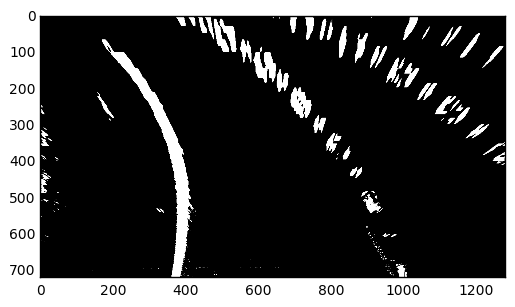

In [1337]:
plt.imshow(top_down, cmap='gray')

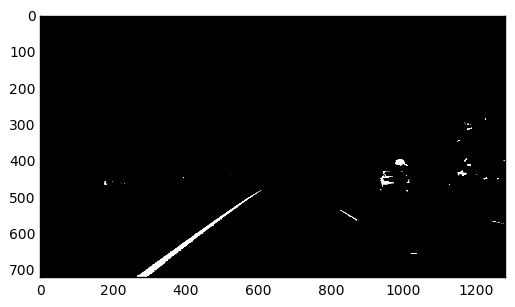

In [1329]:
plt.imshow(s, cmap='gray')

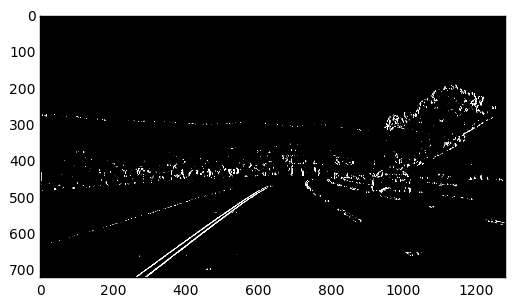

In [1330]:
plt.imshow(slopex, cmap='gray')

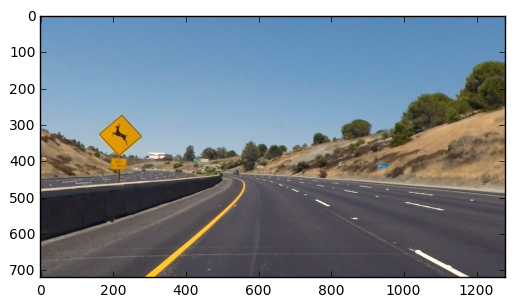

In [1326]:
plt.imshow(undist)

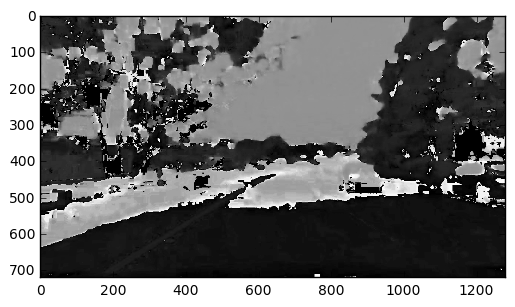

In [1117]:
h = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)[:, :, 0]
plt.imshow(h, cmap='gray')

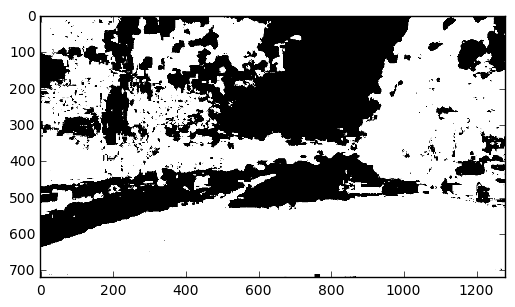

In [1118]:
hhh = np.zeros_like(h)
hhh[h < 100] = 1
plt.imshow(hhh, cmap='gray')

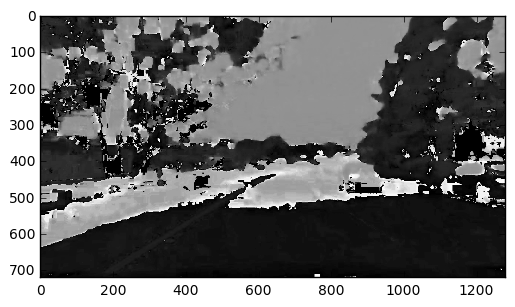

In [1289]:
image = mpimg.imread('./test_images/test5.jpg')
undist, s, slopex, top_down, result = process_image(image)
h = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)[:, :, 0]
plt.imshow(h, cmap='gray')

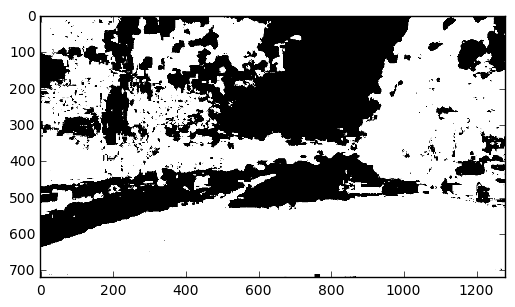

In [1290]:
hhh = np.zeros_like(h)
hhh[h < 100] = 1
plt.imshow(hhh, cmap='gray')

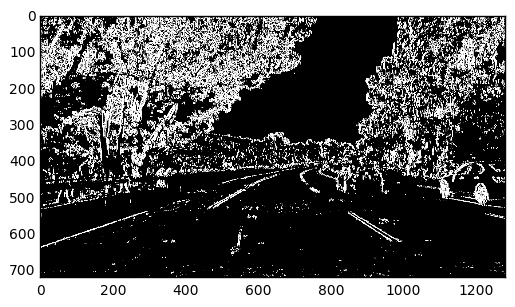

In [1291]:
gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
slopex = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
scale_factor = np.max(slopex) / 255
scale_slopex = (slopex / scale_factor).astype(np.uint8)
sx_binary = np.zeros_like(scale_slopex)
sx_binary[(scale_slopex >= 10) & (scale_slopex <= 255)] = 1
plt.imshow(sx_binary, cmap='gray')

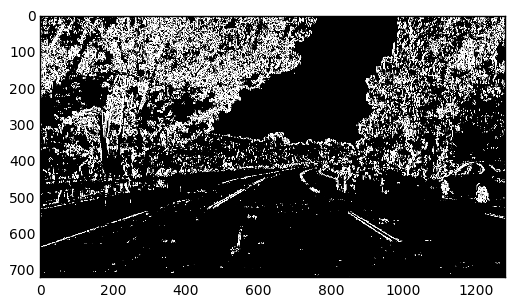

In [1292]:
sx_binary[(scale_slopex >= 20) & (scale_slopex <= 255)] = 1

#sx_binary[(h>10) & (sx_binary == 1)] = 1
#sx_binary[h < 15] = 0
sx_binary[h < 10] = 0
plt.imshow(sx_binary, cmap='gray')

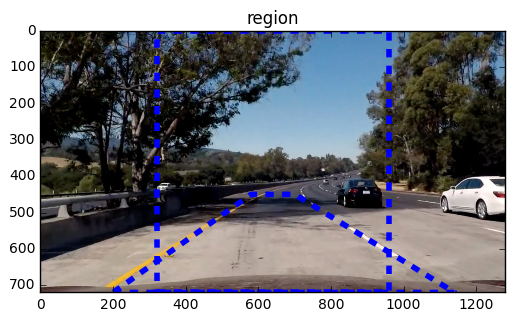

In [969]:
plt.imshow(undist)
img = undist
left_bottom = [img.shape[1] * (20./128), img.shape[0]]
right_bottom = [img.shape[1]* (114./128), img.shape[0]]
apex = [img.shape[1]*(70.0/128), 450]
b = [img.shape[1]*(58./128), 450]

# Display the image and show region and color selections
plt.imshow(img); plt.xlim([0, img.shape[1]]); plt.ylim([img.shape[0], 0])
x = [left_bottom[0], right_bottom[0], apex[0], b[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], b[1], left_bottom[1]]
plt.plot(x, y, 'b--', lw=4); plt.title("region")
left_bottom = [img.shape[1]/4, img.shape[0]]
right_bottom = [img.shape[1]*3/4, img.shape[0]]
apex = [img.shape[1]*3/4, 0]
b = [img.shape[1]/4, 0]
x = [left_bottom[0], right_bottom[0], apex[0], b[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], b[1], left_bottom[1]]
plt.plot(x, y, 'b--', lw=4); plt.title("region")

In [ ]:
    OFFSET = 200
    SRC = np.float32([
        (300, 720),
        (580, 470),
        (730, 470),
        (1100, 720)])

    DST = np.float32([
        (SRC[0][0] - 50 + OFFSET, SRC[0][1]),
        (SRC[0][0] - 50 + OFFSET, 0),
        (SRC[-1][0] - OFFSET, 0),
        (SRC[-1][0] - OFFSET, SRC[0][1])])

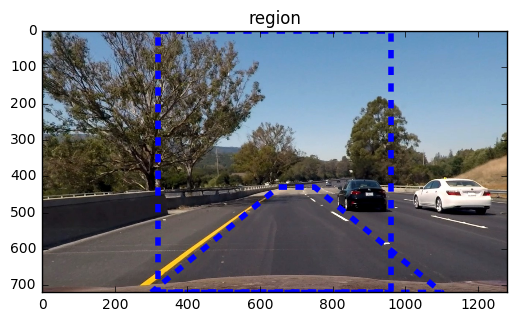

In [629]:
plt.imshow(undist)
img = undist
# left_bottom = [img.shape[1] * (20./128), img.shape[0]]
# right_bottom = [img.shape[1]* (114./128), img.shape[0]]
# apex = [img.shape[1]*(70.0/128), 450]
# b = [img.shape[1]*(58./128), 450]

    SRC = np.float32([
        (300, 720),
        (580, 430),
        (730, 430),
        (1100, 720)])

    DST = np.float32([
        (SRC[0][0] - 50 + OFFSET, SRC[0][1]),
        (SRC[0][0] - 50 + OFFSET, 0),
        (SRC[-1][0] - OFFSET, 0),
        (SRC[-1][0] - OFFSET, SRC[0][1])])

offset=350
left_bottom = [300, 720]
right_bottom = [1100, 720]
apex = [1100-offset, 430]
b = [300+offset, 430]

# Display the image and show region and color selections
plt.imshow(img); plt.xlim([0, img.shape[1]]); plt.ylim([img.shape[0], 0])
x = [left_bottom[0], right_bottom[0], apex[0], b[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], b[1], left_bottom[1]]
plt.plot(x, y, 'b--', lw=4); plt.title("region")
left_bottom = [img.shape[1]/4, img.shape[0]]
right_bottom = [img.shape[1]*3/4, img.shape[0]]
apex = [img.shape[1]*3/4, 0]
b = [img.shape[1]/4, 0]
x = [left_bottom[0], right_bottom[0], apex[0], b[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], b[1], left_bottom[1]]
plt.plot(x, y, 'b--', lw=4); plt.title("region")

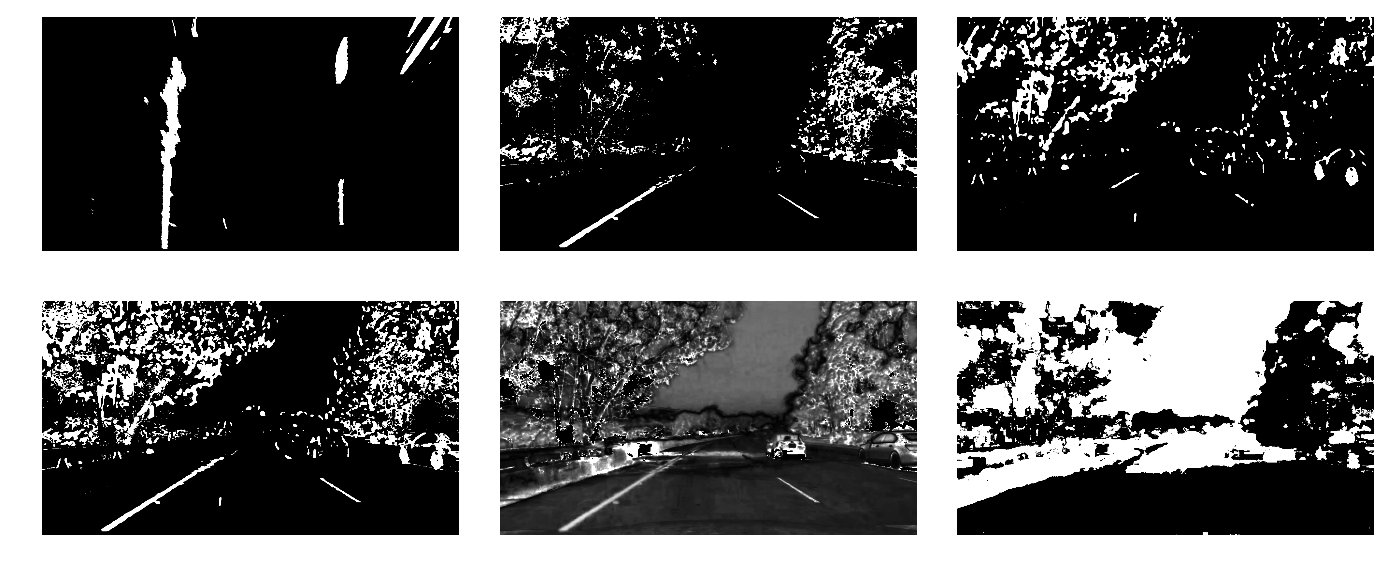

In [249]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline


def get_Binary_From_HLS(h, s, thres_min=110, thres_max=255):
    s_binary = np.zeros_like(s)
    s_binary[((s >= thres_min) & (s <= thres_max)) & (h <= 85)] = 1
    #s_binary[((s >= thres_min) & (s <= thres_max))] = 1
    return s_binary

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def get_slope(undist, orient='x', sobel_kernel=3, thres = (0, 255)):
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        raise KeyError("select 'x' or 'y'")
        
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    return slope_binary

def get_converted_color_img(undist, color=cv2.COLOR_RGB2HLS):
    return cv2.cvtColor(undist, color)

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

class Perspective_Transform():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.inverse_M = cv2.getPerspectiveTransform(self.dst, self.src)
        
    def transform(self, undist):
        return cv2.warpPerspective(undist, self.M, (undist.shape[1], undist.shape[0]))
    
    def inv_transform(self, undist):
        return cv2.warpPerspective(undist, self.inverse_M, (undist.shape[1], undist.shape[0]))

    
class LineDetect():
    def __init__(self, src, dst, do_calibration=None):
        if do_calibration:
            self.calibration_param = do_calibration
        self.src = src
        self.dst = dst
        self.perspective_transform = Perspective_Transform(self.src, self.dst)
        
    def __get_undistortion(self, img):
        mtx = self.calibration_param['mtx']
        dist = self.calibration_param['dist']
        undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        return undist_img
    
    def _color_slope_thres_conversion(self, undist_img):
        undist_img = gaussian_blur(undist_img, kernel_size=5)
        hls = get_converted_color_img(undist_img, cv2.COLOR_RGB2HLS)
        h = hls[:, :, 0]
        s = hls[:, :, 2]
        s_binary = get_Binary_From_HLS(h, s)
        slope = get_slope(undist_img, orient='x', thres=(20, 255))
        slope = gaussian_blur(slope, kernel_size=19)
        color_binary = np.zeros_like(s_binary)
        color_binary[(s_binary == 1) | (slope == 1)] = 1
        return s, h, s_binary, slope, color_binary

    def process_image(self, image):
        undist_img = self.__get_undistortion(image)
        undist_img = adjust_gamma(undist_img, 0.9)
        s, h, s_binary, slope, conversion_img = self._color_slope_thres_conversion(undist_img)
        top_down = self.perspective_transform.transform(conversion_img)
        h[h > 30] = 255
        h[h <= 30] = 0
        return undist_img, s, h, s_binary, slope, conversion_img, top_down

if __name__ == '__main__':
    image = mpimg.imread('./test_images/test5.jpg')
    OFFSET = 200
    SRC = np.float32([
        (300, 720),
        (580, 470),
        (730, 470),
        (1100, 720)])

    DST = np.float32([
        (SRC[0][0] - 50 + OFFSET, SRC[0][1]),
        (SRC[0][0] - 50 + OFFSET, 0),
        (SRC[-1][0] - OFFSET, 0),
        (SRC[-1][0] - OFFSET, SRC[0][1])])
    
    try:
        calibration_param = np.load('./calibration.npz')
    except IOError as e:
        print("There is no file like path")
        
    ld = LineDetect(SRC, DST, do_calibration=calibration_param)
    undist, s, h, color, slope, conversion_img, top_down = ld.process_image(image)
    fig, axes = plt.subplots(2, 3, figsize=(14, 6))
    fig.tight_layout()
    [ax.axis('off') for axe in axes for ax in axe]
    axes[0, 0].imshow(top_down, cmap='gray')
    axes[0, 1].imshow(color, cmap='gray')
    axes[0, 2].imshow(slope, cmap='gray')
    axes[1, 0].imshow(conversion_img, cmap='gray')
    axes[1, 1].imshow(s, cmap='gray')
    axes[1, 2].imshow(h, cmap='gray')
    fig.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.1, hspace = 0.1)

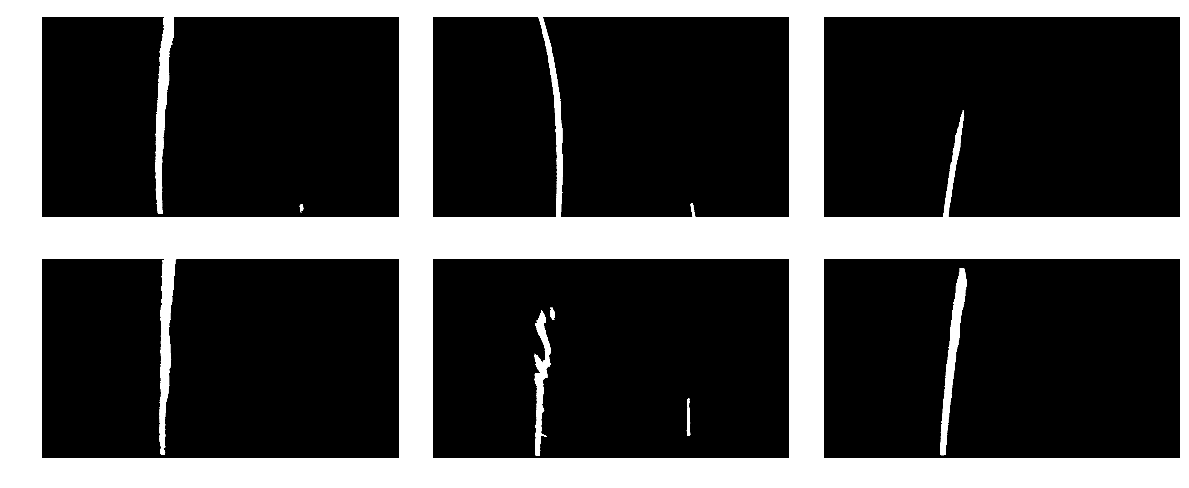

In [230]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline


def get_Binary_From_HLS(h, s, thres_min=110, thres_max=255):
    s_binary = np.zeros_like(s)
    s_binary[((s >= thres_min) & (s <= thres_max)) & (h <= 30)] = 1
    #s_binary[((s >= thres_min) & (s <= thres_max))] = 1
    return s_binary

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def get_converted_color_img(undist, color=cv2.COLOR_RGB2HLS):
    return cv2.cvtColor(undist, color)

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

class Perspective_Transform():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.inverse_M = cv2.getPerspectiveTransform(self.dst, self.src)
        
    def transform(self, undist):
        return cv2.warpPerspective(undist, self.M, (undist.shape[1], undist.shape[0]))
    
    def inv_transform(self, undist):
        return cv2.warpPerspective(undist, self.inverse_M, (undist.shape[1], undist.shape[0]))

    
class LineDetect():
    def __init__(self, src, dst, do_calibration=None):
        if do_calibration:
            self.calibration_param = do_calibration
        self.src = src
        self.dst = dst
        self.perspective_transform = Perspective_Transform(self.src, self.dst)
        
    def __get_undistortion(self, img):
        mtx = self.calibration_param['mtx']
        dist = self.calibration_param['dist']
        undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        return undist_img
    
    def _color_slope_thres_conversion(self, undist_img):
        #undist_img = gaussian_blur(undist_img, kernel_size=15)
        hls = get_converted_color_img(undist_img, cv2.COLOR_RGB2HLS)
        h = hls[:, :, 0]
        s = hls[:, :, 2]
        s_binary = get_Binary_From_HLS(h, s)
        color_binary = np.zeros_like(s_binary)
        color_binary[(s_binary == 1) | (slope == 1)] = 1
        
        s_binary = gaussian_blur(s_binary, kernel_size=17)#9
        return s, h, s_binary, color_binary

    def process_image(self, image):
        undist_img = self.__get_undistortion(image)
        undist_img = adjust_gamma(undist_img, 0.80)
        s, h, s_binary, conversion_img = self._color_slope_thres_conversion(undist_img)
        top_down = self.perspective_transform.transform(s_binary)
        return undist_img, s, h, s_binary, conversion_img, top_down


if __name__ == '__main__':
    OFFSET = 200
    SRC = np.float32([
        (300, 720),
        (580, 470),
        (730, 470),
        (1100, 720)])

    DST = np.float32([
        (SRC[0][0] - 50 + OFFSET, SRC[0][1]),
        (SRC[0][0] - 50 + OFFSET, 0),
        (SRC[-1][0] - OFFSET, 0),
        (SRC[-1][0] - OFFSET, SRC[0][1])])
    
    try:
        calibration_param = np.load('./calibration.npz')
    except IOError as e:
        print("There is no file like path")
        
    fig, axes = plt.subplots(2, 3, figsize=(12, 5))
    for i in range(2):
        for j in range(3):
            image = mpimg.imread("./test_images/test{}.jpg".format(str(i*3 + j + 1)))
            ld = LineDetect(SRC, DST, do_calibration=calibration_param)
            undist, s, h, color, conversion_img, top_down = ld.process_image(image)            
            axes[i, j].imshow(top_down, cmap='gray')
    fig.tight_layout()
    [ax.axis('off') for axe in axes for ax in axe]
    fig.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.1, hspace = 0.1)

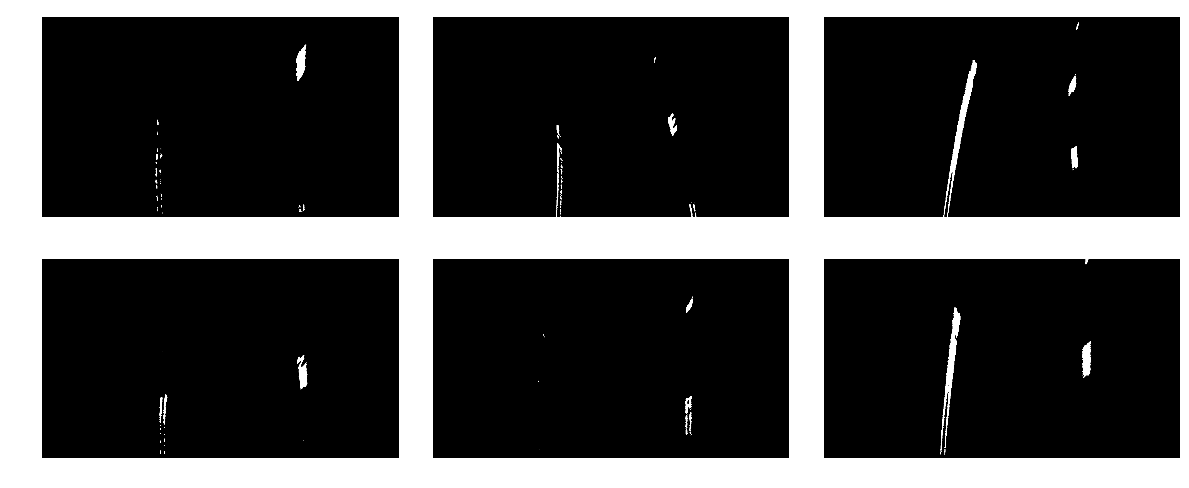

In [644]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline


def get_Binary_From_HLS(h, s, thres_min=110, thres_max=255):
    s_binary = np.zeros_like(s)
    s_binary[((s >= thres_min) & (s <= thres_max)) & (h <= 85)] = 1
    #s_binary[((s >= thres_min) & (s <= thres_max))] = 1
    return s_binary

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def dir_threshold(img_ch, sobel_kernel=3, thresh=(0, np.pi/2)):    
    sobelx = cv2.Sobel(img_ch, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_ch, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    with np.errstate(divide='ignore', invalid='ignore'):
        abs_grad_dir = np.absolute(np.arctan(sobely/sobelx))
        dir_binary =  np.zeros_like(abs_grad_dir)
        dir_binary[(abs_grad_dir > thresh[0]) & (abs_grad_dir < thresh[1])] = 1

    return dir_binary

def get_slope(undist, orient='x', sobel_kernel=3, thres = (0, 255)):
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        raise KeyError("select 'x' or 'y'")
        
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    
#     dir_binary = dir_threshold(gray, sobel_kernel=5, thresh=(np.pi/5, np.pi/2.3))
    dir_binary = dir_threshold(gray, sobel_kernel=5, thresh=(0.80, 1.20))    
    slope_binary[(dir_binary == 0)] = 0
    return slope_binary

def get_converted_color_img(undist, color=cv2.COLOR_RGB2HLS):
    return cv2.cvtColor(undist, color)

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

class Perspective_Transform():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.inverse_M = cv2.getPerspectiveTransform(self.dst, self.src)
        
    def transform(self, undist):
        return cv2.warpPerspective(undist, self.M, (undist.shape[1], undist.shape[0]))
    
    def inv_transform(self, undist):
        return cv2.warpPerspective(undist, self.inverse_M, (undist.shape[1], undist.shape[0]))

    
class LineDetect():
    def __init__(self, src, dst, do_calibration=None):
        if do_calibration:
            self.calibration_param = do_calibration
        self.src = src
        self.dst = dst
        self.perspective_transform = Perspective_Transform(self.src, self.dst)
        
    def __get_undistortion(self, img):
        mtx = self.calibration_param['mtx']
        dist = self.calibration_param['dist']
        undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        return undist_img
    
    def _color_slope_thres_conversion(self, undist_img):
        #undist_img = gaussian_blur(undist_img, kernel_size=3)
        hls = get_converted_color_img(undist_img, cv2.COLOR_RGB2HLS)
        h = hls[:, :, 0]
        s = hls[:, :, 2]
        s_binary = get_Binary_From_HLS(h, s)
        slope = get_slope(undist_img, orient='x',sobel_kernel=5, thres=(20, 255))
        color_binary = np.zeros_like(s_binary)
        color_binary[(s_binary == 1) | (slope == 1)] = 1
        
        slope = gaussian_blur(slope, kernel_size=7)
        return s, h, s_binary, slope, color_binary

    def process_image(self, image):
        undist_img = self.__get_undistortion(image)
        undist_img = adjust_gamma(undist_img, 0.2)
        s, h, s_binary, slope, conversion_img = self._color_slope_thres_conversion(undist_img)
        top_down = self.perspective_transform.transform(slope)
        return undist_img, s, h, s_binary, slope, conversion_img, top_down

if __name__ == '__main__':
    OFFSET = 200
    SRC = np.float32([
        (300, 720),
        (580, 470),
        (730, 470),
        (1100, 720)])

    DST = np.float32([
        (SRC[0][0] - 50 + OFFSET, SRC[0][1]),
        (SRC[0][0] - 50 + OFFSET, 0),
        (SRC[-1][0] - OFFSET, 0),
        (SRC[-1][0] - OFFSET, SRC[0][1])])
#     img_size=(1280, 720)
#     SRC = np.float32([np.array([[img_size[0]*55./128., 450]]), np.array([[img_size[0] * 70. /128, 450]]),
#                       np.array([[img_size[0] *7. / 8, img_size[1]]]), np.array([[img_size[0] * 1. / 8, img_size[1]]])])
#     DST = np.float32([np.array([[img_size[0]/4, 0]]), np.array([[img_size[0] * 3 / 4, 0]]),
#                       np.array([[img_size[0]*3/4, img_size[1]]]), np.array([[img_size[0] / 4, img_size[1]]])])
    
    try:
        calibration_param = np.load('./calibration.npz')
    except IOError as e:
        print("There is no file like path")
        

    fig, axes = plt.subplots(2, 3, figsize=(12, 5))
    for i in range(2):
        for j in range(3):
            image = mpimg.imread("./test_images/test{}.jpg".format(str(i*3 + j + 1)))
            ld = LineDetect(SRC, DST, do_calibration=calibration_param)
            undist, s, h, color, slope, conversion_img, top_down = ld.process_image(image)            
            axes[i, j].imshow(top_down, cmap='gray')
    fig.tight_layout()
    [ax.axis('off') for axe in axes for ax in axe]
    fig.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.1, hspace = 0.1)

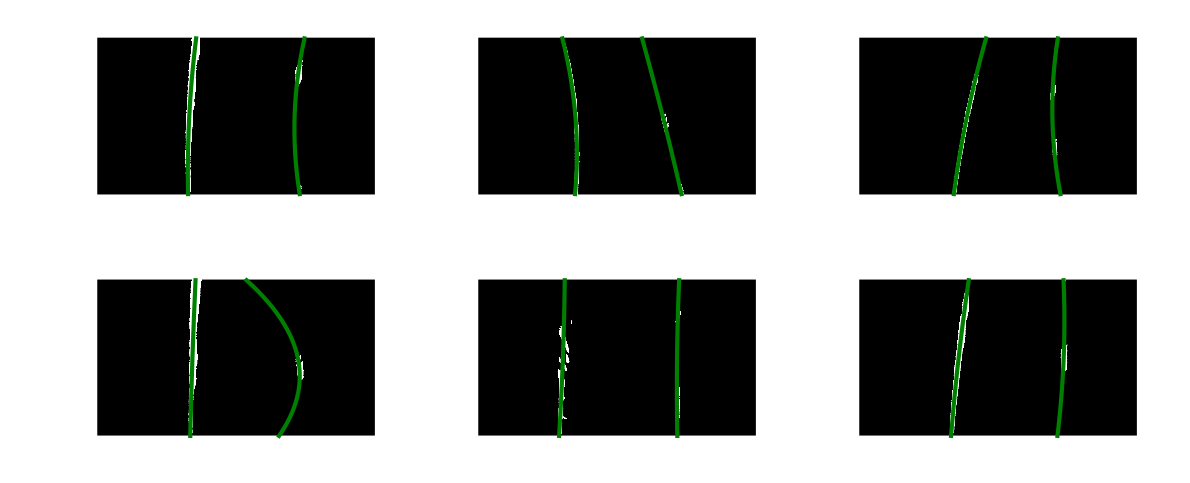

In [448]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline


def get_Binary_From_HLS(undist_img, thres=(110, 255)):
    undist_img = adjust_gamma(undist_img, 0.9)
    hls = get_converted_color_img(undist_img, cv2.COLOR_RGB2HLS)
    h = hls[:, :, 0]
    s = hls[:, :, 2]
    s_binary = np.zeros_like(s)
    s_binary[((s >= thres[0]) & (s <= thres[1])) & (h <= 30)] = 1
    s_binary = gaussian_blur(s_binary, kernel_size=19)#9
    return s_binary

def get_slope(undist_img, orient='x', sobel_kernel=3, thres = (0, 255)):
    undist_img = adjust_gamma(undist_img, 0.2)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        raise KeyError("select 'x' or 'y'")
        
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    
    dir_binary = dir_threshold(gray, sobel_kernel=5, thresh=(0.80, 1.20))    
    slope_binary[(dir_binary == 0)] = 0
    slope_binary = gaussian_blur(slope_binary, kernel_size=7)

    return slope_binary

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def get_converted_color_img(undist, color=cv2.COLOR_RGB2HLS):
    return cv2.cvtColor(undist, color)

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)


class Perspective_Transform():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.inverse_M = cv2.getPerspectiveTransform(self.dst, self.src)
        
    def transform(self, undist):
        return cv2.warpPerspective(undist, self.M, (undist.shape[1], undist.shape[0]))
    
    def inv_transform(self, undist):
        return cv2.warpPerspective(undist, self.inverse_M, (undist.shape[1], undist.shape[0]))

    
class LineDetect():
    def __init__(self, src, dst, do_calibration=None):
        if do_calibration:
            self.calibration_param = do_calibration
        self.src = src
        self.dst = dst
        self.perspective_transform = Perspective_Transform(self.src, self.dst)
        
    def __get_undistortion(self, img):
        mtx = self.calibration_param['mtx']
        dist = self.calibration_param['dist']
        undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        return undist_img
    
    def _color_slope_thres_conversion(self, undist_img):
        s_binary = get_Binary_From_HLS(undist_img, thres=(110, 255))
        slope = get_slope(undist_img, orient='x',sobel_kernel=5, thres=(20, 255))
        
        color_binary = np.zeros_like(s_binary)
        color_binary[(s_binary == 1) | (slope == 1)] = 1
    
        return s, h, s_binary, slope, color_binary

    def process_image(self, image):
        undist_img = self.__get_undistortion(image)
        s, h, s_binary, slope, conversion_img = self._color_slope_thres_conversion(undist_img)
        top_down = self.perspective_transform.transform(conversion_img)
        return undist_img, s, h, s_binary, slope, conversion_img, top_down

def histogram(img, xsteps=20, ysteps=40):
    def get_max_index_of_histogram(histogram, left_boundary, right_boundary, window_width=10):
        index_list = []
        side_histogram = histogram[left_boundary : right_boundary]
        for i in range(len(side_histogram) - window_width):
            index_list.append(np.sum(side_histogram[i : i + window_width]))
        index = np.argmax(index_list) + int(window_width / 2) + left_boundary
        return index
    
    xstride = img.shape[0] // xsteps
    ystride = img.shape[1] // ysteps 
    for xstep in range(xsteps):
        histogram = np.sum(img[xstride*xstep : xstride*(xstep+1), :], axis=0)
        boundary = int(img.shape[1] / 2)
        leftindex = get_max_index_of_histogram(histogram, 0, boundary)
        rightindex = get_max_index_of_histogram(histogram, boundary, img.shape[1])
        
        # mask image
        if histogram[leftindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), : leftindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), leftindex+ysteps+1 : boundary] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), : boundary] = 0
            
        if histogram[rightindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), boundary :rightindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), rightindex+ysteps+1 :] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), boundary : ] = 0
            
    left_fit_line = cal_poly(img, 0, boundary)
    right_fit_line = cal_poly(img, boundary, img.shape[1])
    yvals = np.arange(img.shape[0])
             
    return img, left_fit_line, right_fit_line, yvals

def cal_poly(img, left_boundary, right_boundary):
    side_img = img[:, left_boundary: right_boundary]
    index = np.where(side_img == 1)
    yvals = index[0]
    xvals = index[1] + left_boundary
    fit_equation = np.polyfit(yvals, xvals, 2)
    yvals = np.arange(img.shape[0])
    fit_line = fit_equation[0]*yvals**2 + fit_equation[1]*yvals + fit_equation[2]
    return fit_line

def weighted_img(img, initial_img, a=0.8, b=1., c=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    if initial_img.shape != img.shape:
        img = cv2.resize(img, (initial_img.shape[1], initial_img.shape[0]))
    return cv2.addWeighted(initial_img, a, img, b, c)


if __name__ == '__main__':
    OFFSET = 200
    SRC = np.float32([
        (300, 720),
        (580, 470),
        (730, 470),
        (1100, 720)])

    DST = np.float32([
        (SRC[0][0] - 50 + OFFSET, SRC[0][1]),
        (SRC[0][0] - 50 + OFFSET, 0),
        (SRC[-1][0] - OFFSET, 0),
        (SRC[-1][0] - OFFSET, SRC[0][1])])
    
    try:
        calibration_param = np.load('./calibration.npz')
    except IOError as e:
        print("There is no file like path")
        

    fig, axes = plt.subplots(2, 3, figsize=(12, 5))
    for i in range(2):
        for j in range(3):
            image = mpimg.imread("./test_images/test{}.jpg".format(str(i*3 + j + 1)))
            ld = LineDetect(SRC, DST, do_calibration=calibration_param)
            undist, s, h, color, slope, conversion_img, top_down = ld.process_image(image)   
            #axes[i, j].imshow(histogram(top_down), cmap='gray')
            img, left_fit_line, right_fit_line, yvals = histogram(top_down)
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].plot(left_fit_line, yvals, color='green', linewidth=3)
            axes[i, j].plot(right_fit_line, yvals, color='green', linewidth=3)
            
    fig.tight_layout()
    [ax.axis('off') for axe in axes for ax in axe]
    fig.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.1, hspace = 0.1)

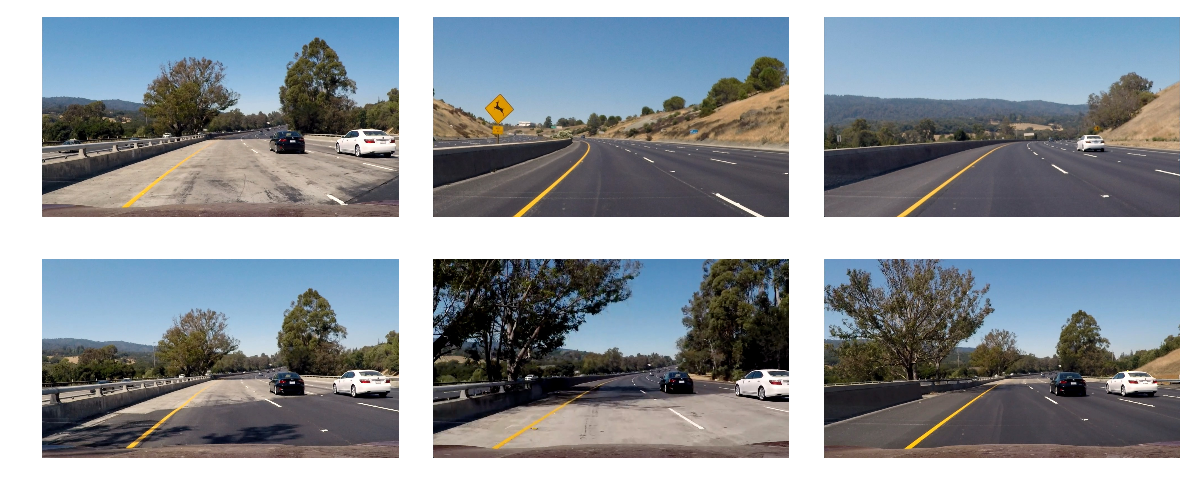

In [120]:
fig, axes = plt.subplots(2, 3, figsize=(12, 5))
for i in range(2):
    for j in range(3):
        image = mpimg.imread("./test_images/test{}.jpg".format(str(i*3 + j + 1)))
        axes[i, j].imshow(image)
fig.tight_layout()
[ax.axis('off') for axe in axes for ax in axe]
fig.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.1, hspace = 0.1)

# final Parameter

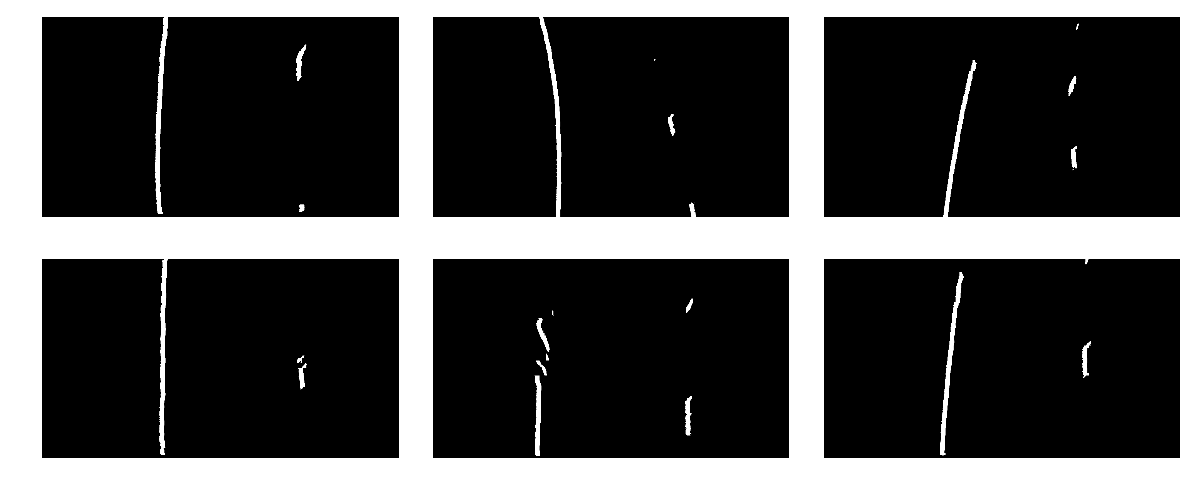

In [744]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline


def get_Binary_From_HLS(undist_img, thres=(110, 255)):
    undist_img = adjust_gamma(undist_img, 0.9)
    hls = get_converted_color_img(undist_img, cv2.COLOR_RGB2HLS)
    h = hls[:, :, 0]
    s = hls[:, :, 2]
    s_binary = np.zeros_like(s)
    s_binary[((s >= thres[0]) & (s <= thres[1])) & (h <= 30)] = 1
    s_binary = gaussian_blur(s_binary, kernel_size=19)#9
    return s_binary

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def get_converted_color_img(undist, color=cv2.COLOR_RGB2HLS):
    return cv2.cvtColor(undist, color)

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def get_slope(undist_img, orient='x', sobel_kernel=3, thres = (0, 255)):
    undist_img = adjust_gamma(undist_img, 0.2)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        raise KeyError("select 'x' or 'y'")
        
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    
    dir_binary = dir_threshold(gray, sobel_kernel=5, thresh=(0.80, 1.20))    
    slope_binary[(dir_binary == 0)] = 0
    slope_binary = gaussian_blur(slope_binary, kernel_size=7)

    return slope_binary


class Perspective_Transform():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.inverse_M = cv2.getPerspectiveTransform(self.dst, self.src)
        
    def transform(self, undist):
        return cv2.warpPerspective(undist, self.M, (undist.shape[1], undist.shape[0]))
    
    def inv_transform(self, undist):
        return cv2.warpPerspective(undist, self.inverse_M, (undist.shape[1], undist.shape[0]))

    
class LineDetect():
    def __init__(self, src, dst, do_calibration=None):
        if do_calibration:
            self.calibration_param = do_calibration
        self.src = src
        self.dst = dst
        self.perspective_transform = Perspective_Transform(self.src, self.dst)
        
    def __get_undistortion(self, img):
        mtx = self.calibration_param['mtx']
        dist = self.calibration_param['dist']
        undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        return undist_img
    
    def _color_slope_thres_conversion(self, undist_img):
        s_binary = get_Binary_From_HLS(undist_img, thres=(110, 255))
        slope = get_slope(undist_img, orient='x',sobel_kernel=5, thres=(20, 255))
        
        color_binary = np.zeros_like(s_binary)
        color_binary[(s_binary == 1) | (slope == 1)] = 1
    
        return s, h, s_binary, slope, color_binary

    def process_image(self, image):
        undist_img = self.__get_undistortion(image)
        s, h, s_binary, slope, conversion_img = self._color_slope_thres_conversion(undist_img)
        top_down = self.perspective_transform.transform(conversion_img)
        top_down, left_lines, right_lines, yvals = histogram(top_down, xsteps=80, ysteps=10)
        new_image = np.zeros_like(top_down)
        for yv, ll in zip(yvals, left_lines):
            new_image[yv, ll-10:ll+10] = 1
        for yv, rl in zip(yvals, right_lines):
            new_image[yv, rl-10 : rl+10] = 1
        
        new_image = self.perspective_transform.inv_transform(new_image)
        color=[255, 0, 0]
        #描画　引数は (画像, 点の配列, 点の数, 色)
        index = np.where(new_image == 1)
#         pt = np.transpose(np.where(new_image == 1))
        pt = np.vstack((index[1], index[0]))
        pt = np.transpose(pt)

        cv2.fillConvexPoly(undist_img, pt, (255, 93, 74))
        undist_img[new_image==1] = color
        return undist_img, s, h, s_binary, slope, conversion_img, top_down, new_image

def histogram(img, xsteps=20, ysteps=40):
    def get_max_index_of_histogram(histogram, left_boundary, right_boundary, window_width=10):
        index_list = []
        side_histogram = histogram[left_boundary : right_boundary]
        for i in range(len(side_histogram) - window_width):
            index_list.append(np.sum(side_histogram[i : i + window_width]))
        index = np.argmax(index_list) + int(window_width / 2) + left_boundary
        return index
    
    xstride = img.shape[0] // xsteps
    ystride = img.shape[1] // ysteps 
    for xstep in range(xsteps):
        histogram = np.sum(img[xstride*xstep : xstride*(xstep+1), :], axis=0)
        boundary = int(img.shape[1] / 2)
        leftindex = get_max_index_of_histogram(histogram, 0, boundary)
        rightindex = get_max_index_of_histogram(histogram, boundary, img.shape[1])
        
        # mask image
        if histogram[leftindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), : leftindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), leftindex+ysteps+1 : boundary] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), : boundary] = 0
            
        if histogram[rightindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), boundary :rightindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), rightindex+ysteps+1 :] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), boundary : ] = 0
            
    left_fit_line = cal_poly(img, 0, boundary)
    right_fit_line = cal_poly(img, boundary, img.shape[1])
    yvals = np.arange(img.shape[0])
             
    return img, left_fit_line, right_fit_line, yvals

def cal_poly(img, left_boundary, right_boundary):
    side_img = img[:, left_boundary: right_boundary]
    index = np.where(side_img == 1)
    yvals = index[0]
    xvals = index[1] + left_boundary
    fit_equation = np.polyfit(yvals, xvals, 2)
    yvals = np.arange(img.shape[0])
    fit_line = fit_equation[0]*yvals**2 + fit_equation[1]*yvals + fit_equation[2]
    return fit_line

if __name__ == '__main__':
    OFFSET = 200
    SRC = np.float32([
        (300, 720),
        (580, 470),
        (730, 470),
        (1100, 720)])

    DST = np.float32([
        (SRC[0][0] - 50 + OFFSET, SRC[0][1]),
        (SRC[0][0] - 50 + OFFSET, 0),
        (SRC[-1][0] - OFFSET, 0),
        (SRC[-1][0] - OFFSET, SRC[0][1])])
    
    try:
        calibration_param = np.load('./calibration.npz')
    except IOError as e:
        print("There is no file like path")
        

    fig, axes = plt.subplots(2, 3, figsize=(12, 5))
    for i in range(2):
        for j in range(3):
            image = mpimg.imread("./test_images/test{}.jpg".format(str(i*3 + j + 1)))
            ld = LineDetect(SRC, DST, do_calibration=calibration_param)
            undist, s, h, color, slope, conversion_img, top_down, new_image = ld.process_image(image)   
#             img, left_fit_line, right_fit_line, yvals = histogram(top_down, xsteps=80, ysteps=10)
#             axes[i, j].imshow(undist, cmap='gray')
            axes[i, j].imshow(top_down, cmap='gray')
#             axes[i, j].plot(left_fit_line, yvals, color='green', linewidth=3)
#             axes[i, j].plot(right_fit_line, yvals, color='green', linewidth=3)
            
    fig.tight_layout()
    [ax.axis('off') for axe in axes for ax in axe]
    fig.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.1, hspace = 0.1)

# final

In [617]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline


def get_Binary_From_HLS(undist_img, thres=(110, 255)):
    undist_img = adjust_gamma(undist_img, 0.9)
    hls = get_converted_color_img(undist_img, cv2.COLOR_RGB2HLS)
    h = hls[:, :, 0]
    s = hls[:, :, 2]
    s_binary = np.zeros_like(s)
    s_binary[((s >= thres[0]) & (s <= thres[1])) & (h <= 30)] = 1
    s_binary = gaussian_blur(s_binary, kernel_size=19)#9
    return s_binary

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def get_converted_color_img(undist, color=cv2.COLOR_RGB2HLS):
    return cv2.cvtColor(undist, color)

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def get_slope(undist_img, orient='x', sobel_kernel=3, thres = (0, 255)):
    undist_img = adjust_gamma(undist_img, 0.2)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        raise KeyError("select 'x' or 'y'")
        
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    
    dir_binary = dir_threshold(gray, sobel_kernel=5, thresh=(0.80, 1.20))    
    slope_binary[(dir_binary == 0)] = 0
    slope_binary = gaussian_blur(slope_binary, kernel_size=7)

    return slope_binary


class Perspective_Transform():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.inverse_M = cv2.getPerspectiveTransform(self.dst, self.src)
        
    def transform(self, undist):
        return cv2.warpPerspective(undist, self.M, (undist.shape[1], undist.shape[0]))
    
    def inv_transform(self, undist):
        return cv2.warpPerspective(undist, self.inverse_M, (undist.shape[1], undist.shape[0]))

    
class LineDetect():
    def __init__(self, src, dst, do_calibration=None):
        if do_calibration:
            self.calibration_param = do_calibration
        self.src = src
        self.dst = dst
        self.perspective_transform = Perspective_Transform(self.src, self.dst)
        
    def __get_undistortion(self, img):
        mtx = self.calibration_param['mtx']
        dist = self.calibration_param['dist']
        undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        return undist_img
    
    def _color_slope_thres_conversion(self, undist_img):
        s_binary = get_Binary_From_HLS(undist_img, thres=(110, 255))
        slope = get_slope(undist_img, orient='x',sobel_kernel=5, thres=(20, 255))
        
        color_binary = np.zeros_like(s_binary)
        color_binary[(s_binary == 1) | (slope == 1)] = 1
    
        return s, h, s_binary, slope, color_binary

    def process_image(self, image):
        undist_img = self.__get_undistortion(image)
        s, h, s_binary, slope, conversion_img = self._color_slope_thres_conversion(undist_img)
        top_down = self.perspective_transform.transform(conversion_img)
        top_down, left_lines, right_lines, yvals = histogram(top_down, xsteps=80, ysteps=5)
        new_image = np.zeros_like(top_down)
        for yv, ll in zip(yvals, left_lines):
            new_image[yv, ll-10:ll+10] = 1
        for yv, rl in zip(yvals, right_lines):
            new_image[yv, rl-10 : rl+10] = 1
        
        new_image = self.perspective_transform.inv_transform(new_image)
        color=[255, 0, 0]
        #描画　引数は (画像, 点の配列, 点の数, 色)
        index = np.where(new_image == 1)
#         pt = np.transpose(np.where(new_image == 1))
        pt = np.vstack((index[1], index[0]))
        pt = np.transpose(pt)

        cv2.fillConvexPoly(undist_img, pt, (255, 93, 74))
        undist_img[new_image==1] = color
        return undist_img

def histogram(img, xsteps=20, ysteps=40):
    def get_max_index_of_histogram(histogram, left_boundary, right_boundary, window_width=10):
        index_list = []
        side_histogram = histogram[left_boundary : right_boundary]
        for i in range(len(side_histogram) - window_width):
            index_list.append(np.sum(side_histogram[i : i + window_width]))
        index = np.argmax(index_list) + int(window_width / 2) + left_boundary
        return index
    
    xstride = img.shape[0] // xsteps
    ystride = img.shape[1] // ysteps 
    for xstep in range(xsteps):
        histogram = np.sum(img[xstride*xstep : xstride*(xstep+1), :], axis=0)
        boundary = int(img.shape[1] / 2)
        leftindex = get_max_index_of_histogram(histogram, 0, boundary)
        rightindex = get_max_index_of_histogram(histogram, boundary, img.shape[1])
        
        # mask image
        if histogram[leftindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), : leftindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), leftindex+ysteps+1 : boundary] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), : boundary] = 0
            
        if histogram[rightindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), boundary :rightindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), rightindex+ysteps+1 :] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), boundary : ] = 0
            
    left_fit_line = cal_poly(img, 0, boundary)
    right_fit_line = cal_poly(img, boundary, img.shape[1])
    yvals = np.arange(img.shape[0])
             
    return img, left_fit_line, right_fit_line, yvals

def cal_poly(img, left_boundary, right_boundary):
    side_img = img[:, left_boundary: right_boundary]
    index = np.where(side_img == 1)
    yvals = index[0]
    xvals = index[1] + left_boundary
    fit_equation = np.polyfit(yvals, xvals, 2)
    yvals = np.arange(img.shape[0])
    fit_line = fit_equation[0]*yvals**2 + fit_equation[1]*yvals + fit_equation[2]
    return fit_line

In [618]:
def process_image(image):
    OFFSET = 200
    SRC = np.float32([
        (300, 720),
        (580, 470),
        (730, 470),
        (1100, 720)])

    DST = np.float32([
        (SRC[0][0] - 50 + OFFSET, SRC[0][1]),
        (SRC[0][0] - 50 + OFFSET, 0),
        (SRC[-1][0] - OFFSET, 0),
        (SRC[-1][0] - OFFSET, SRC[0][1])])
    
    try:
        calibration_param = np.load('./calibration.npz')
    except IOError as e:
        print("There is no file like path")
        
    ld = LineDetect(SRC, DST, do_calibration=calibration_param)
    finish = ld.process_image(image)   
    return finish

In [619]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = './myproject.mp4'
clip1 = VideoFileClip('./project_video.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./myproject.mp4
[MoviePy] Writing video ./myproject.mp4


100%|█████████▉| 1260/1261 [09:28<00:00,  2.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./myproject.mp4 

CPU times: user 27min 16s, sys: 1min 14s, total: 28min 31s
Wall time: 9min 28s


In [549]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./mymini.mp4'))

In [621]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./myproject.mp4'))

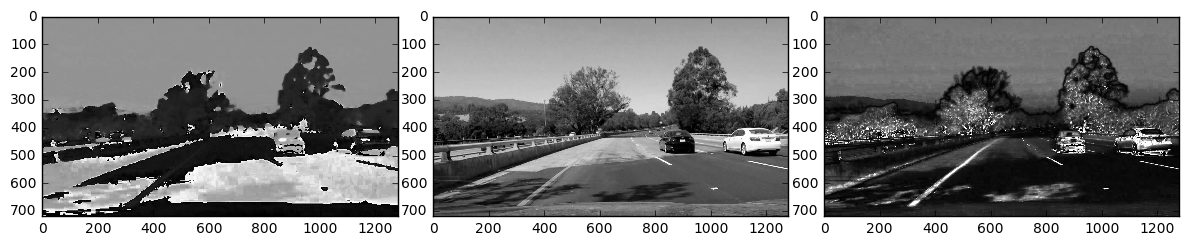

In [571]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline


def get_Binary_From_HLS(undist_img, thres=(110, 255)):
    undist_img = adjust_gamma(undist_img, 0.9)
    hls = get_converted_color_img(undist_img, cv2.COLOR_RGB2HLS)
    h = hls[:, :, 0]
    s = hls[:, :, 2]
    s_binary = np.zeros_like(s)
    s_binary[((s >= thres[0]) & (s <= thres[1])) & (h <= 30)] = 1
    s_binary = gaussian_blur(s_binary, kernel_size=19)#9
    return s_binary

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def get_converted_color_img(undist, color=cv2.COLOR_RGB2HLS):
    return cv2.cvtColor(undist, color)

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def get_slope(undist_img, orient='x', sobel_kernel=3, thres = (0, 255)):
    undist_img = adjust_gamma(undist_img, 0.2)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        raise KeyError("select 'x' or 'y'")
        
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    
    dir_binary = dir_threshold(gray, sobel_kernel=5, thresh=(0.80, 1.20))    
    slope_binary[(dir_binary == 0)] = 0
    slope_binary = gaussian_blur(slope_binary, kernel_size=7)

    return slope_binary


class Perspective_Transform():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.inverse_M = cv2.getPerspectiveTransform(self.dst, self.src)
        
    def transform(self, undist):
        return cv2.warpPerspective(undist, self.M, (undist.shape[1], undist.shape[0]))
    
    def inv_transform(self, undist):
        return cv2.warpPerspective(undist, self.inverse_M, (undist.shape[1], undist.shape[0]))

    
class LineDetect():
    def __init__(self, src, dst, do_calibration=None):
        if do_calibration:
            self.calibration_param = do_calibration
        self.src = src
        self.dst = dst
        self.perspective_transform = Perspective_Transform(self.src, self.dst)
        
    def __get_undistortion(self, img):
        mtx = self.calibration_param['mtx']
        dist = self.calibration_param['dist']
        undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        return undist_img
    
    def _color_slope_thres_conversion(self, undist_img):
        s_binary = get_Binary_From_HLS(undist_img, thres=(110, 255))
        slope = get_slope(undist_img, orient='x',sobel_kernel=5, thres=(20, 255))
#         white = get_white_line(undist_img)
        hls = get_converted_color_img(undist_img, cv2.COLOR_RGB2HLS)
        h = hls[:, :, 0]
        l = hls[:, :, 1]
        s = hls[:, :, 2]
        
        color_binary = np.zeros_like(s_binary)
        color_binary[(s_binary == 1) | (slope == 1)] = 1
    
        return h, l, s

    def process_image(self, image):
        undist_img = self.__get_undistortion(image)
        h, l, s = self._color_slope_thres_conversion(undist_img)
#         top_down = self.perspective_transform.transform(conversion_img)
#         top_down, left_lines, right_lines, yvals = histogram(top_down, xsteps=80, ysteps=10)
#         new_image = np.zeros_like(top_down)
#         for yv, ll in zip(yvals, left_lines):
#             new_image[yv, ll-10:ll+10] = 1
#         for yv, rl in zip(yvals, right_lines):
#             new_image[yv, rl-10 : rl+10] = 1
        
#         new_image = self.perspective_transform.inv_transform(new_image)
#         color=[255, 0, 0]
#         index = np.where(new_image == 1)
#         pt = np.vstack((index[1], index[0]))
#         pt = np.transpose(pt)

#         cv2.fillConvexPoly(undist_img, pt, (255, 93, 74))
#         undist_img[new_image==1] = color
        return h, l, s

def histogram(img, xsteps=20, ysteps=40):
    def get_max_index_of_histogram(histogram, left_boundary, right_boundary, window_width=10):
        index_list = []
        side_histogram = histogram[left_boundary : right_boundary]
        for i in range(len(side_histogram) - window_width):
            index_list.append(np.sum(side_histogram[i : i + window_width]))
        index = np.argmax(index_list) + int(window_width / 2) + left_boundary
        return index
    
    xstride = img.shape[0] // xsteps
    ystride = img.shape[1] // ysteps 
    for xstep in range(xsteps):
        histogram = np.sum(img[xstride*xstep : xstride*(xstep+1), :], axis=0)
        boundary = int(img.shape[1] / 2)
        leftindex = get_max_index_of_histogram(histogram, 0, boundary)
        rightindex = get_max_index_of_histogram(histogram, boundary, img.shape[1])
        
        # mask image
        if histogram[leftindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), : leftindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), leftindex+ysteps+1 : boundary] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), : boundary] = 0
            
        if histogram[rightindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), boundary :rightindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), rightindex+ysteps+1 :] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), boundary : ] = 0
            
    left_fit_line = cal_poly(img, 0, boundary)
    right_fit_line = cal_poly(img, boundary, img.shape[1])
    yvals = np.arange(img.shape[0])
             
    return img, left_fit_line, right_fit_line, yvals

def cal_poly(img, left_boundary, right_boundary):
    side_img = img[:, left_boundary: right_boundary]
    index = np.where(side_img == 1)
    yvals = index[0]
    xvals = index[1] + left_boundary
    fit_equation = np.polyfit(yvals, xvals, 2)
    yvals = np.arange(img.shape[0])
    fit_line = fit_equation[0]*yvals**2 + fit_equation[1]*yvals + fit_equation[2]
    return fit_line

if __name__ == '__main__':
    OFFSET = 200
    SRC = np.float32([
        (300, 720),
        (580, 470),
        (730, 470),
        (1100, 720)])

    DST = np.float32([
        (SRC[0][0] - 50 + OFFSET, SRC[0][1]),
        (SRC[0][0] - 50 + OFFSET, 0),
        (SRC[-1][0] - OFFSET, 0),
        (SRC[-1][0] - OFFSET, SRC[0][1])])
    
    try:
        calibration_param = np.load('./calibration.npz')
    except IOError as e:
        print("There is no file like path")
        
    image = mpimg.imread('./test_images/test4.jpg')
    ld = LineDetect(SRC, DST, do_calibration=calibration_param)
#     h, l, s = ld.process_image(image)   
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    h = hls[:, :, 0]
    l = hls[:, :, 1]
    s = hls[:, :, 2]
#     img, left_fit_line, right_fit_line, yvals = histogram(top_down, xsteps=80, ysteps=10)
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    axes[0].imshow(h, cmap='gray')
    axes[1].imshow(l, cmap='gray')
    axes[2].imshow(s, cmap='gray')

    fig.tight_layout()
    fig.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.1, hspace = 0.1)

def get_Binary_From_HLS(undist_img, thres=(110, 255)):
    undist_img = adjust_gamma(undist_img, 0.9)
    hls = get_converted_color_img(undist_img, cv2.COLOR_RGB2HLS)
    h = hls[:, :, 0]
    s = hls[:, :, 2]
    s_binary = np.zeros_like(s)
    s_binary[((s >= thres[0]) & (s <= thres[1])) & (h <= 30)] = 1
    s_binary = gaussian_blur(s_binary, kernel_size=19)#9
    return s_binary

def get_white_line(hsv_img):
    undist_img = adjust_gamma(undist_img, 0.9)
    hls = get_converted_color_img(undist_img, cv2.COLOR_RGB2HLS)
    h = hls[:, :, 0]
    s = hls[:, :, 2]
    s_binary = np.zeros_like(s)
    s_binary[((s >= thres[0]) & (s <= thres[1])) & (h <= 30)] = 1
    s_binary = gaussian_blur(s_binary, kernel_size=19)#9
    return s_binary

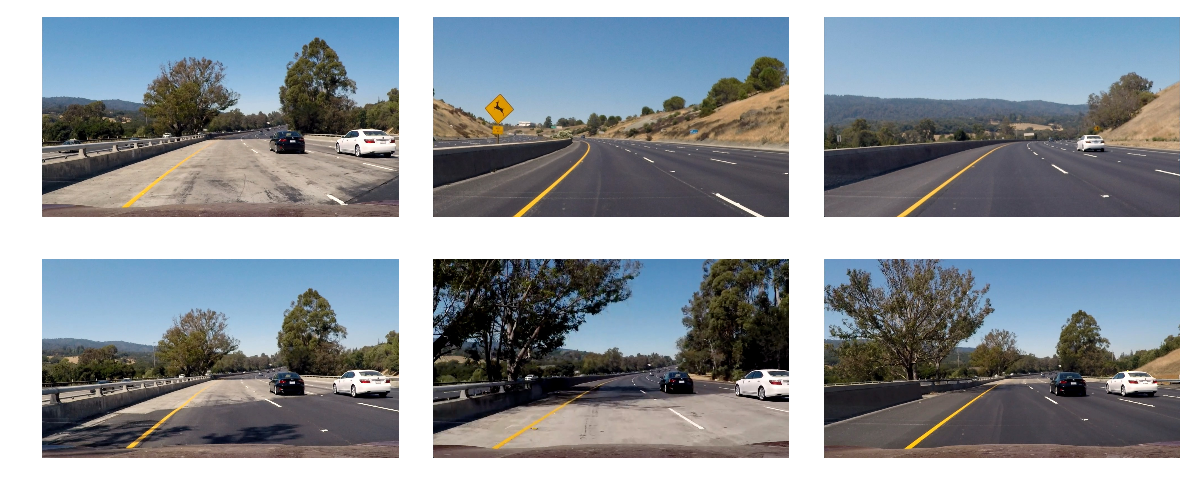

In [560]:
fig, axes = plt.subplots(2, 3, figsize=(12, 5))
for i in range(2):
    for j in range(3):
        image = mpimg.imread("./test_images/test{}.jpg".format(str(i*3 + j + 1)))
        axes[i, j].imshow(image)
fig.tight_layout()
[ax.axis('off') for axe in axes for ax in axe]
fig.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.1, hspace = 0.1)

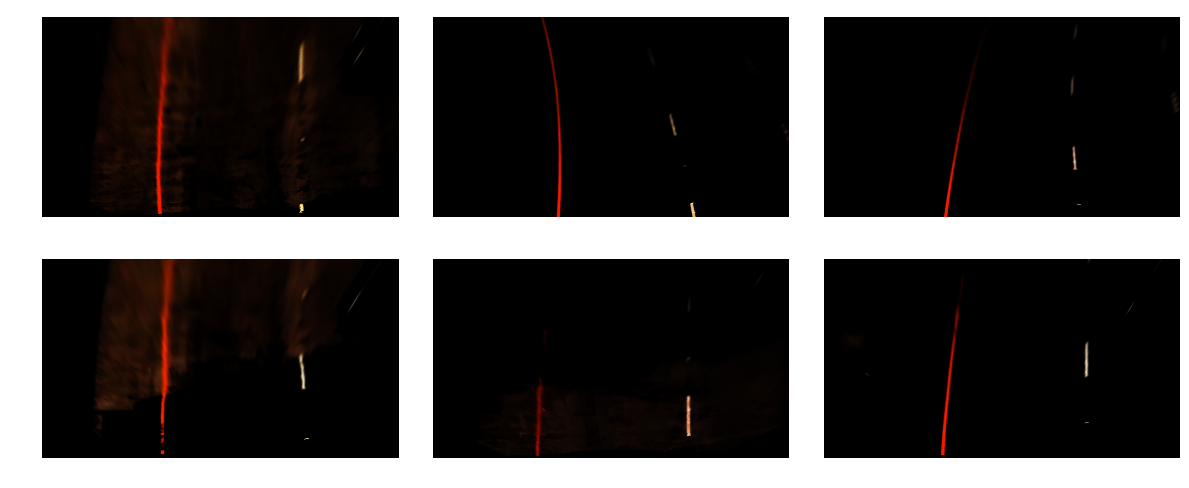

In [807]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline


def get_Binary_From_HLS(undist_img, thres=(110, 255)):
    undist_img = adjust_gamma(undist_img, 0.1)
    hls = get_converted_color_img(undist_img, cv2.COLOR_RGB2HLS)
    h = hls[:, :, 0]
    s = hls[:, :, 2]
    s_binary = np.zeros_like(s)
    s_binary[((s >= thres[0]) & (s <= thres[1])) & (h <= 30)] = 1
    s_binary = gaussian_blur(s_binary, kernel_size=19)#9
    return s_binary

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def get_converted_color_img(undist, color=cv2.COLOR_RGB2HLS):
    return cv2.cvtColor(undist, color)

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def get_slope(undist_img, orient='x', sobel_kernel=3, thres = (0, 255)):
    undist_img = adjust_gamma(undist_img, 0.2)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        raise KeyError("select 'x' or 'y'")
        
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    
    dir_binary = dir_threshold(gray, sobel_kernel=5, thresh=(0.80, 1.20))    
    slope_binary[(dir_binary == 0)] = 0
    slope_binary = gaussian_blur(slope_binary, kernel_size=7)

    return slope_binary

def get_white_line(undist_img, thres=(80, 255)):#110
    undist_img = adjust_gamma(undist_img, 0.9)
    hls = get_converted_color_img(undist_img, cv2.COLOR_RGB2HLS)
    h = hls[:, :, 0]
    s = hls[:, :, 2]
    s_binary = np.zeros_like(s)
#     s_binary[((s >= thres[0]) & (s <= thres[1])) & (h <= 30)] = 1
    s_binary[((s >= thres[0]) & (s <= thres[1]))] = 1
#     s_binary = gaussian_blur(s_binary, kernel_size=19)#9
    h_binary = np.zeros_like(h)
    h_binary[(h >21 ) & (h < 25)] = 1
    return h_binary

def get_white_line(undist_img, thres=(80, 255)):#110
    undist_img = gaussian_blur(undist_img, kernel_size=5)#9
    undist_img = adjust_gamma(undist_img, 0.1)
    hls = get_converted_color_img(undist_img, cv2.COLOR_RGB2HLS)
    h = hls[:, :, 0]
    s = hls[:, :, 2]
    s_binary = np.zeros_like(s)
#     s_binary[((s >= thres[0]) & (s <= thres[1])) & (h <= 30)] = 1
    s_binary[((s >= thres[0]) & (s <= thres[1]))] = 1
#     s_binary = gaussian_blur(s_binary, kernel_size=19)#9
    h_binary = np.zeros_like(h)
#     h_binary[(h >15 ) & (h < 25)] = 1
    h_binary[(h < 25)] = 1

    return undist_img

class LineDetect():
    def __init__(self, src, dst, do_calibration=None):
        if do_calibration:
            self.calibration_param = do_calibration
        self.src = src
        self.dst = dst
        self.perspective_transform = Perspective_Transform(self.src, self.dst)
        
    def __get_undistortion(self, img):
        mtx = self.calibration_param['mtx']
        dist = self.calibration_param['dist']
        undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        return undist_img
    
    def _color_slope_thres_conversion(self, undist_img):
        s_binary = get_Binary_From_HLS(undist_img, thres=(110, 255))
        slope = get_slope(undist_img, orient='x',sobel_kernel=5, thres=(20, 255))
        white = get_white_line(undist_img)
        
        color_binary = np.zeros_like(s_binary)
        color_binary[(s_binary == 1) | (slope == 1)] = 1
    
        return s, h, s_binary, slope, color_binary, white

    def process_image(self, image):
        undist_img = self.__get_undistortion(image)
        s, h, s_binary, slope, conversion_img, white = self._color_slope_thres_conversion(undist_img)
        top_down = self.perspective_transform.transform(conversion_img)
        return undist_img, s, h, s_binary, slope, conversion_img, top_down

def histogram(img, xsteps=20, ysteps=40):
    def get_max_index_of_histogram(histogram, left_boundary, right_boundary, window_width=10):
        index_list = []
        side_histogram = histogram[left_boundary : right_boundary]
        for i in range(len(side_histogram) - window_width):
            index_list.append(np.sum(side_histogram[i : i + window_width]))
        index = np.argmax(index_list) + int(window_width / 2) + left_boundary
        return index
    
    xstride = img.shape[0] // xsteps
    ystride = img.shape[1] // ysteps 
    for xstep in range(xsteps):
        histogram = np.sum(img[xstride*xstep : xstride*(xstep+1), :], axis=0)
        boundary = int(img.shape[1] / 2)
        leftindex = get_max_index_of_histogram(histogram, 0, boundary)
        rightindex = get_max_index_of_histogram(histogram, boundary, img.shape[1])
        
        # mask image
        if histogram[leftindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), : leftindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), leftindex+ysteps+1 : boundary] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), : boundary] = 0
            
        if histogram[rightindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), boundary :rightindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), rightindex+ysteps+1 :] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), boundary : ] = 0
            
    left_fit_line = cal_poly(img, 0, boundary)
    right_fit_line = cal_poly(img, boundary, img.shape[1])
    yvals = np.arange(img.shape[0])
             
    return img, left_fit_line, right_fit_line, yvals

def cal_poly(img, left_boundary, right_boundary):
    side_img = img[:, left_boundary: right_boundary]
    index = np.where(side_img == 1)
    yvals = index[0]
    xvals = index[1] + left_boundary
    fit_equation = np.polyfit(yvals, xvals, 2)
    yvals = np.arange(img.shape[0])
    fit_line = fit_equation[0]*yvals**2 + fit_equation[1]*yvals + fit_equation[2]
    return fit_line

if __name__ == '__main__':
    OFFSET = 200
    SRC = np.float32([
        (300, 720),
        (580, 470),
        (730, 470),
        (1100, 720)])

    DST = np.float32([
        (SRC[0][0] - 50 + OFFSET, SRC[0][1]),
        (SRC[0][0] - 50 + OFFSET, 0),
        (SRC[-1][0] - OFFSET, 0),
        (SRC[-1][0] - OFFSET, SRC[0][1])])
    
    try:
        calibration_param = np.load('./calibration.npz')
    except IOError as e:
        print("There is no file like path")
        

    fig, axes = plt.subplots(2, 3, figsize=(12, 5))
    for i in range(2):
        for j in range(3):
            image = mpimg.imread("./test_images/test{}.jpg".format(str(i*3 + j + 1)))
            ld = LineDetect(SRC, DST, do_calibration=calibration_param)
            undist, s, h, color, slope, conversion_img, top_down = ld.process_image(image)   
            axes[i, j].imshow(top_down, cmap='gray')
            
    fig.tight_layout()
    [ax.axis('off') for axe in axes for ax in axe]
    fig.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.1, hspace = 0.1)

In [870]:
def histogram(img, xsteps=20, ysteps=40, window_width=10):
    def get_max_index_of_histogram(histogram, left_boundary, right_boundary, window_width=10):
        index_list = []
        side_histogram = histogram[left_boundary : right_boundary]
        for i in range(len(side_histogram) - window_width):
            index_list.append(np.sum(side_histogram[i : i + window_width]))
        index = np.argmax(index_list) + int(window_width / 2) + left_boundary
        return index
    
    xstride = img.shape[0] // xsteps
    ystride = img.shape[1] // ysteps 
    for xstep in range(xsteps):
        histogram = np.sum(img[xstride*xstep : xstride*(xstep+1), :], axis=0)
        boundary = int(img.shape[1] / 2)
        leftindex = get_max_index_of_histogram(histogram, 0, boundary, window_width=window_width)
        rightindex = get_max_index_of_histogram(histogram, boundary, img.shape[1], window_width=window_width)
        
        # mask image
        if histogram[leftindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), : leftindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), leftindex+ysteps+1 : boundary] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), : boundary] = 0
            
        if histogram[rightindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), boundary :rightindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), rightindex+ysteps+1 :] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), boundary : ] = 0
            
    left_fit_line = cal_poly(img, 0, boundary)
    right_fit_line = cal_poly(img, boundary, img.shape[1])
    yvals = np.arange(img.shape[0])
             
    return img, left_fit_line, right_fit_line, yvals

def cal_poly(img, left_boundary, right_boundary):
    side_img = img[:, left_boundary: right_boundary]
    index = np.where(side_img == 1)
    yvals = index[0]
    xvals = index[1] + left_boundary
    fit_equation = np.polyfit(yvals, xvals, 2)
    yvals = np.arange(img.shape[0])
    fit_line = fit_equation[0]*yvals**2 + fit_equation[1]*yvals + fit_equation[2]
    return fit_line

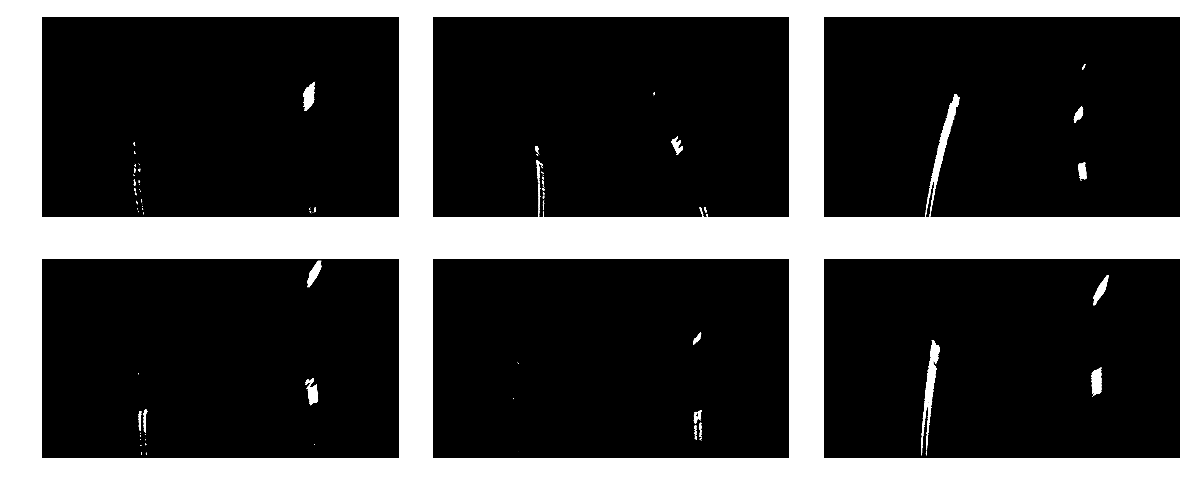

In [876]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline


def get_Binary_From_HLS(undist_img, thres=(110, 255)):
    undist_img = adjust_gamma(undist_img, 0.9)
    hls = get_converted_color_img(undist_img, cv2.COLOR_RGB2HLS)
    h = hls[:, :, 0]
    s = hls[:, :, 2]
    s_binary = np.zeros_like(s)
    s_binary[((s >= thres[0]) & (s <= thres[1])) & (h <= 30)] = 1
    s_binary = gaussian_blur(s_binary, kernel_size=19)#9
    return s_binary

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def get_converted_color_img(undist, color=cv2.COLOR_RGB2HLS):
    return cv2.cvtColor(undist, color)

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def get_slope(undist_img, orient='x', sobel_kernel=3, thres = (0, 255)):
    undist_img = adjust_gamma(undist_img, 0.2)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        raise KeyError("select 'x' or 'y'")
        
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    
    dir_binary = dir_threshold(gray, sobel_kernel=5, thresh=(0.80, 1.20))    
    slope_binary[(dir_binary == 0)] = 0
    slope_binary = gaussian_blur(slope_binary, kernel_size=7)

    return slope_binary



def cal_poly(img, left_boundary, right_boundary):
    side_img = img[:, left_boundary: right_boundary]
    index = np.where(side_img == 1)
    yvals = index[0]
    xvals = index[1] + left_boundary
    fit_equation = np.polyfit(yvals, xvals, 2)
    yvals = np.arange(img.shape[0])
    fit_line = fit_equation[0]*yvals**2 + fit_equation[1]*yvals + fit_equation[2]
    return fit_line


class Perspective_Transform():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.inverse_M = cv2.getPerspectiveTransform(self.dst, self.src)
        
    def transform(self, undist):
        return cv2.warpPerspective(undist, self.M, (undist.shape[1], undist.shape[0]))
    
    def inv_transform(self, undist):
        return cv2.warpPerspective(undist, self.inverse_M, (undist.shape[1], undist.shape[0]))

    
class LineDetect():
    def __init__(self, src, dst, do_calibration=None):
        if do_calibration:
            self.calibration_param = do_calibration
        self.src = src
        self.dst = dst
        self.perspective_transform = Perspective_Transform(self.src, self.dst)
        
    def __get_undistortion(self, img):
        mtx = self.calibration_param['mtx']
        dist = self.calibration_param['dist']
        undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        return undist_img
    
    def _color_slope_thres_conversion(self, undist_img):
        s_binary = get_Binary_From_HLS(undist_img, thres=(110, 255))
        slope = get_slope(undist_img, orient='x',sobel_kernel=5, thres=(20, 255))
        
        color_binary = np.zeros_like(s_binary)
        color_binary[(s_binary == 1) | (slope == 1)] = 1
    
        return s, h, s_binary, slope, color_binary

    def process_image(self, image):
        undist_img = self.__get_undistortion(image)
        s, h, s_binary, slope, conversion_img = self._color_slope_thres_conversion(undist_img)
        top_down = self.perspective_transform.transform(slope)
        top_down[:, :100] = 0
        top_down[:, 1150:] = 0
        return top_down
#         top_down, left_lines, right_lines, yvals = histogram(top_down, xsteps=20, ysteps=5, window_width=15)
#         new_image = np.zeros_like(top_down)
#         for yv, ll in zip(yvals, left_lines):
#             new_image[yv, ll-10:ll+10] = 1
#         for yv, rl in zip(yvals, right_lines):
#             new_image[yv, rl-10 : rl+10] = 1
        
#         new_image = self.perspective_transform.inv_transform(new_image)
#         color=[255, 0, 0]
#         index = np.where(new_image == 1)
#         pt = np.vstack((index[1], index[0]))
#         pt = np.transpose(pt)

#         cv2.fillConvexPoly(undist_img, pt, (255, 93, 74))
#         undist_img[new_image==1] = color
#         return undist_img
    

if __name__ == '__main__':
    SRC = np.float32([
        (200, 720),
        (585, 460),
        (725, 460),
        (1140, 720)])
    
    DST = np.float32([
        (320, SRC[0][1]),
        (320, 0),
        (960, 0),
        (960, SRC[0][1])])
    
    try:
        calibration_param = np.load('./calibration.npz')
    except IOError as e:
        print("There is no file like path")
        

    fig, axes = plt.subplots(2, 3, figsize=(12, 5))
    for i in range(2):
        for j in range(3):
            image = mpimg.imread("./test_images/test{}.jpg".format(str(i*3 + j + 1)))
            ld = LineDetect(SRC, DST, do_calibration=calibration_param)
            top_down = ld.process_image(image)   
            axes[i, j].imshow(top_down, cmap='gray')
            
    fig.tight_layout()
    [ax.axis('off') for axe in axes for ax in axe]
    fig.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.1, hspace = 0.1)

# 完成品

In [877]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline


def get_Binary_From_HLS(undist_img, thres=(110, 255)):
    undist_img = adjust_gamma(undist_img, 0.9)
    hls = get_converted_color_img(undist_img, cv2.COLOR_RGB2HLS)
    h = hls[:, :, 0]
    s = hls[:, :, 2]
    s_binary = np.zeros_like(s)
    s_binary[((s >= thres[0]) & (s <= thres[1])) & (h <= 30)] = 1
    s_binary = gaussian_blur(s_binary, kernel_size=19)#9
    return s_binary

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def get_converted_color_img(undist, color=cv2.COLOR_RGB2HLS):
    return cv2.cvtColor(undist, color)

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def get_slope(undist_img, orient='x', sobel_kernel=3, thres = (0, 255)):
    undist_img = adjust_gamma(undist_img, 0.2)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        raise KeyError("select 'x' or 'y'")
        
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    
    dir_binary = dir_threshold(gray, sobel_kernel=5, thresh=(0.80, 1.20))    
    slope_binary[(dir_binary == 0)] = 0
    slope_binary = gaussian_blur(slope_binary, kernel_size=7)

    return slope_binary


def histogram(img, xsteps=20, ysteps=40, window_width=10):
    def get_max_index_of_histogram(histogram, left_boundary, right_boundary, window_width=10):
        index_list = []
        side_histogram = histogram[left_boundary : right_boundary]
        for i in range(len(side_histogram) - window_width):
            index_list.append(np.sum(side_histogram[i : i + window_width]))
        index = np.argmax(index_list) + int(window_width / 2) + left_boundary
        return index
    
    xstride = img.shape[0] // xsteps
    ystride = img.shape[1] // ysteps 
    for xstep in range(xsteps):
        histogram = np.sum(img[xstride*xstep : xstride*(xstep+1), :], axis=0)
        boundary = int(img.shape[1] / 2)
        leftindex = get_max_index_of_histogram(histogram, 0, boundary, window_width=window_width)
        rightindex = get_max_index_of_histogram(histogram, boundary, img.shape[1], window_width=window_width)
        
        # mask image
        if histogram[leftindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), : leftindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), leftindex+ysteps+1 : boundary] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), : boundary] = 0
            
        if histogram[rightindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), boundary :rightindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), rightindex+ysteps+1 :] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), boundary : ] = 0
            
    left_fit_line = cal_poly(img, 0, boundary)
    right_fit_line = cal_poly(img, boundary, img.shape[1])
    yvals = np.arange(img.shape[0])
             
    return img, left_fit_line, right_fit_line, yvals

def cal_poly(img, left_boundary, right_boundary):
    side_img = img[:, left_boundary: right_boundary]
    index = np.where(side_img == 1)
    yvals = index[0]
    xvals = index[1] + left_boundary
    fit_equation = np.polyfit(yvals, xvals, 2)
    yvals = np.arange(img.shape[0])
    fit_line = fit_equation[0]*yvals**2 + fit_equation[1]*yvals + fit_equation[2]
    return fit_line


class Perspective_Transform():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.inverse_M = cv2.getPerspectiveTransform(self.dst, self.src)
        
    def transform(self, undist):
        return cv2.warpPerspective(undist, self.M, (undist.shape[1], undist.shape[0]))
    
    def inv_transform(self, undist):
        return cv2.warpPerspective(undist, self.inverse_M, (undist.shape[1], undist.shape[0]))

    
class LineDetect():
    def __init__(self, src, dst, do_calibration=None):
        if do_calibration:
            self.calibration_param = do_calibration
        self.src = src
        self.dst = dst
        self.perspective_transform = Perspective_Transform(self.src, self.dst)
        
    def __get_undistortion(self, img):
        mtx = self.calibration_param['mtx']
        dist = self.calibration_param['dist']
        undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        return undist_img
    
    def _color_slope_thres_conversion(self, undist_img):
        s_binary = get_Binary_From_HLS(undist_img, thres=(110, 255))
        slope = get_slope(undist_img, orient='x',sobel_kernel=5, thres=(20, 255))
        
        color_binary = np.zeros_like(s_binary)
        color_binary[(s_binary == 1) | (slope == 1)] = 1
    
        return s, h, s_binary, slope, color_binary

    def process_image(self, image):
        undist_img = self.__get_undistortion(image)
        s, h, s_binary, slope, conversion_img = self._color_slope_thres_conversion(undist_img)
        top_down = self.perspective_transform.transform(conversion_img)
        top_down[:, :100] = 0
        top_down[:, 1150:] = 0
        top_down, left_lines, right_lines, yvals = histogram(top_down, xsteps=20, ysteps=10, window_width=15)
        new_image = np.zeros_like(top_down)
        for yv, ll in zip(yvals, left_lines):
            new_image[yv, ll-10:ll+10] = 1
        for yv, rl in zip(yvals, right_lines):
            new_image[yv, rl-10 : rl+10] = 1
        
        new_image = self.perspective_transform.inv_transform(new_image)
        color=[255, 0, 0]
        index = np.where(new_image == 1)
        pt = np.vstack((index[1], index[0]))
        pt = np.transpose(pt)

        cv2.fillConvexPoly(undist_img, pt, (255, 93, 74))
        undist_img[new_image==1] = color
        return undist_img

In [878]:
def process_image(image):
#     OFFSET = 105
#     SRC = np.float32([
#     (380, 720),
#     (620, 455),
#     (720, 455),
#     (1200, 720)])
#     a = 50
#     DST = np.float32([
#         (SRC[0][0] - a + OFFSET, SRC[0][1]),
#         (SRC[0][0] - a + OFFSET, 0),
#         (SRC[-1][0] - OFFSET, 0),
#         (SRC[-1][0] - OFFSET, SRC[0][1])])
#     OFFSET = 200 BEST
#     SRC = np.float32([
#         (300, 720),
#         (580, 455),
#         (730, 455),
#         (1100, 720)])
#     OFFSET = 140
#     SRC = np.float32([
#         (300, 720),
#         (595, 455),
#         (700, 455),
#         (1100, 720)])



#     OFFSET = 200
#     SRC = np.float32([
#         (300, 720),
#         (595, 455),
#         (700, 455),
#         (1100, 720)])

#     DST = np.float32([
#         (SRC[0][0] - 50 + OFFSET, SRC[0][1]),
#         (SRC[0][0] - 50 + OFFSET, 0),
#         (SRC[-1][0] - OFFSET, 0),
#         (SRC[-1][0] - OFFSET, SRC[0][1])])
    SRC = np.float32([
        (200, 720),
        (585, 460),
        (725, 460),
        (1140, 720)])
    
    DST = np.float32([
        (320, SRC[0][1]),
        (320, 0),
        (960, 0),
        (960, SRC[0][1])])
    
    try:
        calibration_param = np.load('./calibration.npz')
    except IOError as e:
        print("There is no file like path")
        
    ld = LineDetect(SRC, DST, do_calibration=calibration_param)
    finish = ld.process_image(image)   
    return finish

In [879]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = './my.mp4'
clip1 = VideoFileClip('./project_video.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./my.mp4
[MoviePy] Writing video ./my.mp4


100%|█████████▉| 1260/1261 [05:50<00:00,  3.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./my.mp4 

CPU times: user 19min 48s, sys: 1min 41s, total: 21min 29s
Wall time: 5min 50s


In [880]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [884]:
def get_slope(undist_img, orient='x', sobel_kernel=3, thres = (0, 255)):
    undist_img = adjust_gamma(undist_img, 0.2)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        raise KeyError("select 'x' or 'y'")
        
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    
    dir_binary = dir_threshold(gray, sobel_kernel=5, thresh=(0.80, 1.20))    
    slope_binary[(dir_binary == 0)] = 0
    slope_binary = gaussian_blur(slope_binary, kernel_size=3)

    return slope_binary

class LineDetect():
    def __init__(self, src, dst, do_calibration=None):
        if do_calibration:
            self.calibration_param = do_calibration
        self.src = src
        self.dst = dst
        self.perspective_transform = Perspective_Transform(self.src, self.dst)
        
    def __get_undistortion(self, img):
        mtx = self.calibration_param['mtx']
        dist = self.calibration_param['dist']
        undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        return undist_img
    
    def _color_slope_thres_conversion(self, undist_img):
        s_binary = get_Binary_From_HLS(undist_img, thres=(110, 255))
        slope = get_slope(undist_img, orient='x',sobel_kernel=5, thres=(20, 255))
        
        color_binary = np.zeros_like(s_binary)
        color_binary[(s_binary == 1) | (slope == 1)] = 1
    
        return s, h, s_binary, slope, color_binary

    def process_image(self, image):
        undist_img = self.__get_undistortion(image)
        s, h, s_binary, slope, conversion_img = self._color_slope_thres_conversion(undist_img)
        top_down = self.perspective_transform.transform(conversion_img)
        top_down[:, :100] = 0
        top_down[:, 1150:] = 0
        top_down, left_lines, right_lines, yvals = histogram(top_down, xsteps=30, ysteps=10, window_width=15)
        new_image = np.zeros_like(top_down)
        for yv, ll in zip(yvals, left_lines):
            new_image[yv, ll-10:ll+10] = 1
        for yv, rl in zip(yvals, right_lines):
            new_image[yv, rl-10 : rl+10] = 1
        
        new_image = self.perspective_transform.inv_transform(new_image)
        color=[255, 0, 0]
        index = np.where(new_image == 1)
        pt = np.vstack((index[1], index[0]))
        pt = np.transpose(pt)

        cv2.fillConvexPoly(undist_img, pt, (255, 93, 74))
        undist_img[new_image==1] = color
        return undist_img

In [885]:
def process_image(image):
    SRC = np.float32([
        (200, 720),
        (585, 460),
        (725, 460),
        (1140, 720)])
    
    DST = np.float32([
        (320, SRC[0][1]),
        (320, 0),
        (960, 0),
        (960, SRC[0][1])])
    
    try:
        calibration_param = np.load('./calibration.npz')
    except IOError as e:
        print("There is no file like path")
        
    ld = LineDetect(SRC, DST, do_calibration=calibration_param)
    finish = ld.process_image(image)   
    return finish

In [886]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = './slope_change.mp4'
clip1 = VideoFileClip('./project_video.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./slope_change.mp4
[MoviePy] Writing video ./slope_change.mp4


100%|█████████▉| 1260/1261 [06:22<00:00,  3.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./slope_change.mp4 

CPU times: user 21min 57s, sys: 1min 34s, total: 23min 31s
Wall time: 6min 23s


In [887]:
def get_slope(undist_img, orient='x', sobel_kernel=3, thres = (0, 255)):
    undist_img = adjust_gamma(undist_img, 0.2)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        raise KeyError("select 'x' or 'y'")
        
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    
    dir_binary = dir_threshold(gray, sobel_kernel=sobel_kernel, thresh=(0.80, 1.20))    
    slope_binary[(dir_binary == 0)] = 0
    slope_binary = gaussian_blur(slope_binary, kernel_size=3)

    return slope_binary

class LineDetect():
    def __init__(self, src, dst, do_calibration=None):
        if do_calibration:
            self.calibration_param = do_calibration
        self.src = src
        self.dst = dst
        self.perspective_transform = Perspective_Transform(self.src, self.dst)
        
    def __get_undistortion(self, img):
        mtx = self.calibration_param['mtx']
        dist = self.calibration_param['dist']
        undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        return undist_img
    
    def _color_slope_thres_conversion(self, undist_img):
        s_binary = get_Binary_From_HLS(undist_img, thres=(110, 255))
        slope = get_slope(undist_img, orient='x',sobel_kernel=13, thres=(30, 255))
        
        color_binary = np.zeros_like(s_binary)
        color_binary[(s_binary == 1) | (slope == 1)] = 1
    
        return s, h, s_binary, slope, color_binary

    def process_image(self, image):
        undist_img = self.__get_undistortion(image)
        s, h, s_binary, slope, conversion_img = self._color_slope_thres_conversion(undist_img)
        top_down = self.perspective_transform.transform(conversion_img)
        top_down[:, :100] = 0
        top_down[:, 1150:] = 0
        top_down, left_lines, right_lines, yvals = histogram(top_down, xsteps=30, ysteps=10, window_width=15)
        new_image = np.zeros_like(top_down)
        for yv, ll in zip(yvals, left_lines):
            new_image[yv, ll-10:ll+10] = 1
        for yv, rl in zip(yvals, right_lines):
            new_image[yv, rl-10 : rl+10] = 1
        
        new_image = self.perspective_transform.inv_transform(new_image)
        color=[255, 0, 0]
        index = np.where(new_image == 1)
        pt = np.vstack((index[1], index[0]))
        pt = np.transpose(pt)

        cv2.fillConvexPoly(undist_img, pt, (255, 93, 74))
        undist_img[new_image==1] = color
        return undist_img

In [891]:
def process_image(image):
    SRC = np.float32([
        (200, 720),
        (585, 460),
        (725, 460),
        (1140, 720)])
    
    DST = np.float32([
        (320, SRC[0][1]),
        (320, 0),
        (960, 0),
        (960, SRC[0][1])])
    
    try:
        calibration_param = np.load('./calibration.npz')
    except IOError as e:
        print("There is no file like path")
        
    ld = LineDetect(SRC, DST, do_calibration=calibration_param)
    finish = ld.process_image(image)   
    return finish

In [889]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = './slope_change_13.mp4'
clip1 = VideoFileClip('./project_video.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./slope_change_13.mp4
[MoviePy] Writing video ./slope_change_13.mp4


100%|█████████▉| 1260/1261 [07:02<00:00,  2.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./slope_change_13.mp4 

CPU times: user 23min 3s, sys: 1min 43s, total: 24min 46s
Wall time: 7min 2s


In [893]:
def get_slope(undist_img, orient='x', sobel_kernel=3, thres = (0, 255)):
    undist_img = adjust_gamma(undist_img, 0.2)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        raise KeyError("select 'x' or 'y'")
        
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    
    dir_binary = dir_threshold(gray, sobel_kernel=sobel_kernel, thresh=(0.80, 1.20))    
    slope_binary[(dir_binary == 0)] = 0
    slope_binary = gaussian_blur(slope_binary, kernel_size=7)

    return slope_binary

class LineDetect():
    def __init__(self, src, dst, do_calibration=None):
        if do_calibration:
            self.calibration_param = do_calibration
        self.src = src
        self.dst = dst
        self.perspective_transform = Perspective_Transform(self.src, self.dst)
        
    def __get_undistortion(self, img):
        mtx = self.calibration_param['mtx']
        dist = self.calibration_param['dist']
        undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        return undist_img
    
    def _color_slope_thres_conversion(self, undist_img):
        s_binary = get_Binary_From_HLS(undist_img, thres=(110, 255))
        slope = get_slope(undist_img, orient='x',sobel_kernel=13, thres=(30, 255))
        
        color_binary = np.zeros_like(s_binary)
        color_binary[(s_binary == 1) | (slope == 1)] = 1
    
        return s, h, s_binary, slope, color_binary

    def process_image(self, image):
        undist_img = self.__get_undistortion(image)
        s, h, s_binary, slope, conversion_img = self._color_slope_thres_conversion(undist_img)
        top_down = self.perspective_transform.transform(conversion_img)
        top_down[:, :100] = 0
        top_down[:, 1150:] = 0
        top_down[:, 600: 680] = 0
        top_down, left_lines, right_lines, yvals = histogram(top_down, xsteps=30, ysteps=15, window_width=20)
        new_image = np.zeros_like(top_down)
        for yv, ll in zip(yvals, left_lines):
            new_image[yv, ll-10:ll+10] = 1
        for yv, rl in zip(yvals, right_lines):
            new_image[yv, rl-10 : rl+10] = 1
        
        new_image = self.perspective_transform.inv_transform(new_image)
        color=[255, 0, 0]
        index = np.where(new_image == 1)
        pt = np.vstack((index[1], index[0]))
        pt = np.transpose(pt)

        cv2.fillConvexPoly(undist_img, pt, (255, 93, 74))
        undist_img[new_image==1] = color
        return undist_img

In [894]:
def process_image(image):
    SRC = np.float32([
        (200, 720),
        (585, 460),
        (725, 460),
        (1140, 720)])
    
    DST = np.float32([
        (320, SRC[0][1]),
        (320, 0),
        (960, 0),
        (960, SRC[0][1])])
    
    try:
        calibration_param = np.load('./calibration.npz')
    except IOError as e:
        print("There is no file like path")
        
    ld = LineDetect(SRC, DST, do_calibration=calibration_param)
    finish = ld.process_image(image)   
    return finish

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = './slope_change_13.mp4'
clip1 = VideoFileClip('./project_video.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./slope_change_13.mp4
[MoviePy] Writing video ./slope_change_13.mp4


100%|█████████▉| 1260/1261 [06:59<00:00,  2.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./slope_change_13.mp4 

CPU times: user 23min 11s, sys: 1min 42s, total: 24min 54s
Wall time: 7min


In [897]:
def histogram(img, xsteps=20, ysteps=40, window_width=10):
    def get_max_index_of_histogram(histogram, left_boundary, right_boundary, window_width=10):
        index_list = []
        side_histogram = histogram[left_boundary : right_boundary]
        for i in range(len(side_histogram) - window_width):
            index_list.append(np.sum(side_histogram[i : i + window_width]))
        index = np.argmax(index_list) + int(window_width / 2) + left_boundary
        return index
    
    xstride = img.shape[0] // xsteps
    ystride = img.shape[1] // ysteps 
    for xstep in range(xsteps):
        histogram = np.sum(img[xstride*xstep : xstride*(xstep+1), :], axis=0)
        boundary = int(img.shape[1] / 2)
        leftindex = get_max_index_of_histogram(histogram, 0, boundary, window_width=window_width)
        rightindex = get_max_index_of_histogram(histogram, boundary, img.shape[1], window_width=window_width)
        
        # mask image
        if histogram[leftindex] >= 5:
            img[xstride*xstep : xstride*(xstep+1), : leftindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), leftindex+ysteps+1 : boundary] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), : boundary] = 0
            
        if histogram[rightindex] >= 5:
            img[xstride*xstep : xstride*(xstep+1), boundary :rightindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), rightindex+ysteps+1 :] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), boundary : ] = 0
            
    left_fit_line = cal_poly(img, 0, boundary)
    right_fit_line = cal_poly(img, boundary, img.shape[1])
    yvals = np.arange(img.shape[0])
             
    return img, left_fit_line, right_fit_line, yvals


In [898]:
def get_slope(undist_img, orient='x', sobel_kernel=3, thres = (0, 255)):
    undist_img = adjust_gamma(undist_img, 0.3)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        raise KeyError("select 'x' or 'y'")
        
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    
    dir_binary = dir_threshold(gray, sobel_kernel=sobel_kernel, thresh=(0.80, 1.20))    
    slope_binary[(dir_binary == 0)] = 0
    slope_binary = gaussian_blur(slope_binary, kernel_size=5)

    return slope_binary

class LineDetect():
    def __init__(self, src, dst, do_calibration=None):
        if do_calibration:
            self.calibration_param = do_calibration
        self.src = src
        self.dst = dst
        self.perspective_transform = Perspective_Transform(self.src, self.dst)
        
    def __get_undistortion(self, img):
        mtx = self.calibration_param['mtx']
        dist = self.calibration_param['dist']
        undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        return undist_img
    
    def _color_slope_thres_conversion(self, undist_img):
        s_binary = get_Binary_From_HLS(undist_img, thres=(110, 255))
        slope = get_slope(undist_img, orient='x',sobel_kernel=13, thres=(32, 255))
        
        color_binary = np.zeros_like(s_binary)
        color_binary[(s_binary == 1) | (slope == 1)] = 1
    
        return s, h, s_binary, slope, color_binary

    def process_image(self, image):
        undist_img = self.__get_undistortion(image)
        s, h, s_binary, slope, conversion_img = self._color_slope_thres_conversion(undist_img)
        top_down = self.perspective_transform.transform(conversion_img)
        top_down[:, :100] = 0
        top_down[:, 1150:] = 0
        top_down[:, 600: 680] = 0
        top_down, left_lines, right_lines, yvals = histogram(top_down, xsteps=30, ysteps=40, window_width=20)
        new_image = np.zeros_like(top_down)
        for yv, ll in zip(yvals, left_lines):
            new_image[yv, ll-10:ll+10] = 1
        for yv, rl in zip(yvals, right_lines):
            new_image[yv, rl-10 : rl+10] = 1
        
        new_image = self.perspective_transform.inv_transform(new_image)
        color=[255, 0, 0]
        index = np.where(new_image == 1)
        pt = np.vstack((index[1], index[0]))
        pt = np.transpose(pt)

        cv2.fillConvexPoly(undist_img, pt, (255, 93, 74))
        undist_img[new_image==1] = color
        return undist_img

In [899]:
def process_image(image):
    SRC = np.float32([
        (200, 720),
        (585, 460),
        (725, 460),
        (1140, 720)])
    
    DST = np.float32([
        (320, SRC[0][1]),
        (320, 0),
        (960, 0),
        (960, SRC[0][1])])
    
    try:
        calibration_param = np.load('./calibration.npz')
    except IOError as e:
        print("There is no file like path")
        
    ld = LineDetect(SRC, DST, do_calibration=calibration_param)
    finish = ld.process_image(image)   
    return finish

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = './slope_change_13.mp4'
clip1 = VideoFileClip('./project_video.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./slope_change_13.mp4
[MoviePy] Writing video ./slope_change_13.mp4


100%|█████████▉| 1260/1261 [06:32<00:00,  3.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./slope_change_13.mp4 

CPU times: user 23min 9s, sys: 1min 20s, total: 24min 30s
Wall time: 6min 33s


In [901]:
def get_slope(undist_img, orient='x', sobel_kernel=3, thres = (0, 255)):
    undist_img = adjust_gamma(undist_img, 0.3)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        raise KeyError("select 'x' or 'y'")
        
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    
    dir_binary = dir_threshold(gray, sobel_kernel=sobel_kernel, thresh=(0.80, 1.20))    
    slope_binary[(dir_binary == 0)] = 0
    slope_binary = gaussian_blur(slope_binary, kernel_size=3)

    return slope_binary

class LineDetect():
    def __init__(self, src, dst, do_calibration=None):
        if do_calibration:
            self.calibration_param = do_calibration
        self.src = src
        self.dst = dst
        self.perspective_transform = Perspective_Transform(self.src, self.dst)
        
    def __get_undistortion(self, img):
        mtx = self.calibration_param['mtx']
        dist = self.calibration_param['dist']
        undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        return undist_img
    
    def _color_slope_thres_conversion(self, undist_img):
        s_binary = get_Binary_From_HLS(undist_img, thres=(110, 255))
        slope = get_slope(undist_img, orient='x',sobel_kernel=13, thres=(30, 255))
        
        color_binary = np.zeros_like(s_binary)
        color_binary[(s_binary == 1) | (slope == 1)] = 1
    
        return s, h, s_binary, slope, color_binary

    def process_image(self, image):
        undist_img = self.__get_undistortion(image)
        s, h, s_binary, slope, conversion_img = self._color_slope_thres_conversion(undist_img)
        top_down = self.perspective_transform.transform(conversion_img)
        top_down[:, :100] = 0
        top_down[:, 1150:] = 0
        top_down[:, 600: 680] = 0
        top_down, left_lines, right_lines, yvals = histogram(top_down, xsteps=30, ysteps=40, window_width=20)
        new_image = np.zeros_like(top_down)
        for yv, ll in zip(yvals, left_lines):
            new_image[yv, ll-10:ll+10] = 1
        for yv, rl in zip(yvals, right_lines):
            new_image[yv, rl-10 : rl+10] = 1
        
        new_image = self.perspective_transform.inv_transform(new_image)
        color=[255, 0, 0]
        index = np.where(new_image == 1)
        pt = np.vstack((index[1], index[0]))
        pt = np.transpose(pt)

        cv2.fillConvexPoly(undist_img, pt, (255, 93, 74))
        undist_img[new_image==1] = color
        return undist_img

In [903]:
def process_image(image):
    SRC = np.float32([
        (200, 720),
        (585, 460),
        (725, 460),
        (1140, 720)])
    
    DST = np.float32([
        (320, SRC[0][1]),
        (320, 0),
        (960, 0),
        (960, SRC[0][1])])
    
    try:
        calibration_param = np.load('./calibration.npz')
    except IOError as e:
        print("There is no file like path")
        
    ld = LineDetect(SRC, DST, do_calibration=calibration_param)
    finish = ld.process_image(image)   
    return finish

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = './slope_change_la.mp4'
clip1 = VideoFileClip('./project_video.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./slope_change_la.mp4
[MoviePy] Writing video ./slope_change_la.mp4



100%|█████████▉| 1260/1261 [06:27<00:00,  3.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./slope_change_la.mp4 

CPU times: user 22min 41s, sys: 1min 23s, total: 24min 4s
Wall time: 6min 28s
